In [1]:
!pip install -U scipy==1.8
!git clone https://github.com/Marcos-L/MI-EEG-ClassMeth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 34.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 65.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.17 requires scipy>=1.10.0, but you have scipy 1.8.0 which is incompatible.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0

In [2]:
cd /kaggle/working/MI-EEG-ClassMeth

/kaggle/working/MI-EEG-ClassMeth


In [3]:
from MI_EEG_ClassMeth.MIfunctions import Window_band_CSP_eppoch, flatt, elastic_net_feats

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
cd /kaggle/working/

/kaggle/working


In [5]:
!pip install pickle5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=125213 sha256=e1e2871d42532dea986169b95c07fcc1cdc2af518fc1c4a8d72e376abc862513
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5


In [ ]:
import pickle as pkl
import os
import time
from shutil import copy2
import json
import mne
import pickle

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import cohen_kappa_score, roc_auc_score, accuracy_score, \
                            f1_score, recall_score, precision_score, make_scorer
from scipy.signal import freqz, filtfilt, resample
from scipy.signal import butter as bw
from joblib import dump, load

In [7]:
import numpy as np
from scipy.signal import resample
import pickle5 as pickle
import warnings
import mne
from time import time
warnings.filterwarnings('ignore')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import cohen_kappa_score, roc_auc_score, accuracy_score, \
                            f1_score, recall_score, precision_score, make_scorer
from scipy.signal import freqz, filtfilt, resample
from scipy.signal import butter as bw
from joblib import dump, load

# tensorlfow 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, AveragePooling2D, BatchNormalization, Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import L1L2

# scikeras
# from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score

In [8]:
def butterworth_digital_filter(X, N, Wn, btype, fs, axis=-1, padtype=None, padlen=0, method='pad', irlen=None):
  """
  Apply digital butterworth filter
  INPUT
  ------
  1. X: (D array)
    array with signals.
  2. N: (int+)
    The order of the filter.
  3. Wn: (float+ or 1D array)
    The critical frequency or frequencies. For lowpass and highpass filters, Wn is a scalar; for bandpass and bandstop filters, Wn is a length-2 vector.
    For a Butterworth filter, this is the point at which the gain drops to 1/sqrt(2) that of the passband (the “-3 dB point”).
    If fs is not specified, Wn units are normalized from 0 to 1, where 1 is the Nyquist frequency (Wn is thus in half cycles / sample and defined as 2*critical frequencies / fs). If fs is specified, Wn is in the same units as fs.
  4. btype: (str) {‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}
    The type of filter
  5. fs: (float+)
    The sampling frequency of the digital system.
  6. axis: (int), Default=1.
    The axis of x to which the filter is applied.
  7. padtype: (str) or None, {'odd', 'even', 'constant'}
    This determines the type of extension to use for the padded signal to which the filter is applied. If padtype is None, no padding is used. The default is ‘odd’.
  8. padlen: (int+) or None, Default=0
    The number of elements by which to extend x at both ends of axis before applying the filter. This value must be less than x.shape[axis] - 1. padlen=0 implies no padding.
  9. method: (str), {'pad', 'gust'}
    Determines the method for handling the edges of the signal, either “pad” or “gust”. When method is “pad”, the signal is padded; the type of padding is determined by padtype
    and padlen, and irlen is ignored. When method is “gust”, Gustafsson’s method is used, and padtype and padlen are ignored.
  10. irlen: (int) or None, Default=nONE
    When method is “gust”, irlen specifies the length of the impulse response of the filter. If irlen is None, no part of the impulse response is ignored.
    For a long signal, specifying irlen can significantly improve the performance of the filter.
  OUTPUT
  ------
  X_fil: (D array)
    array with filtered signals.
  """
  b, a = bw(N, Wn, btype, analog=False, output='ba', fs=fs)
  return filtfilt(b, a, X, axis=axis, padtype=padtype, padlen=padlen, method=method, irlen=irlen)

class TimeFrequencyRpr(BaseEstimator, TransformerMixin):
  """
  Time frequency representation of EEG signals.

  Parameters
  ----------
    1. sfreq:  (float) Sampling frequency in Hz.
    2. f_bank: (2D array) Filter banks Frequencies. Default=None
    3. vwt:    (2D array) Interest time windows. Default=None
  Methods
  -------
    1. fit(X, y=None)
    2. transform(X, y=None)
  """
  def __init__(self, sfreq, f_bank=None, vwt=None):
    self.sfreq = sfreq
    self.f_bank = f_bank
    self.vwt = vwt
# ------------------------------------------------------------------------------

  def _validation_param(self):
    """
    Validate Time-Frequency characterization parameters.
    INPUT
    -----
      1. self
    ------
      2. None
    """
    if self.sfreq <= 0:
      raise ValueError('Non negative sampling frequency is accepted')


    if self.f_bank is None:
      self.flag_f_bank = False
    elif self.f_bank.ndim != 2:
      raise ValueError('Band frequencies have to be a 2D array')
    else:
      self.flag_f_bank = True

    if self.vwt is None:
      self.flag_vwt = False
    elif self.vwt.ndim != 2:
      raise ValueError('Time windows have to be a 2D array')
    else:
      self.flag_vwt = True

# ------------------------------------------------------------------------------
  def _filter_bank(self, X):
    """
    Filter bank Characterization.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
    OUTPUT
    ------
      1. X_f: (4D array) set of filtered EEG signals, shape (trials, channels, time_samples, frequency_bands)
    """
    X_f = np.zeros((X.shape[0], X.shape[1], X.shape[2], self.f_bank.shape[0])) #epochs, Ch, Time, bands
    for f in np.arange(self.f_bank.shape[0]):
      X_f[:,:,:,f] = butterworth_digital_filter(X, N=5, Wn=self.f_bank[f], btype='bandpass', fs=self.sfreq)
    return X_f

# ------------------------------------------------------------------------------
  def _sliding_windows(self, X):
    """
    Sliding Windows Characterization.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
    OUTPUT
    ------
      1. X_w: (4D array) shape (trials, channels, window_time_samples, number_of_windows)
    """
    window_lenght = int(self.sfreq*self.vwt[0,1] - self.sfreq*self.vwt[0,0])
    X_w = np.zeros((X.shape[0], X.shape[1], window_lenght, self.vwt.shape[0]))
    for w in np.arange(self.vwt.shape[0]):
        X_w[:,:,:,w] = X[:,:,int(self.sfreq*self.vwt[w,0]):int(self.sfreq*self.vwt[w,1])]
    return X_w

# ------------------------------------------------------------------------------
  def fit(self, X, y=None):
    """
    fit.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, time_samples)
      2. y: (1D array) target labels. Default=None
    OUTPUT
    ------
      1. None
    """
    pass

# ------------------------------------------------------------------------------
  def transform(self, X, y=None):
    """
    Time frequency representation of EEG signals.
    INPUT
    -----
      1. X: (3D array) set of EEG signals, shape (trials, channels, times)
    OUTPUT
    ------
      1. X_wf: (5D array) Time-frequency representation of EEG signals, shape (trials, channels, window_time_samples, number_of_windows, frequency_bands)
    """
    self._validation_param()     #Validate sfreq, f_freq, vwt

    #Avoid edge effects of digital filter, 1st:fbk, 2th:vwt
    if self.flag_f_bank:
        X_f = self._filter_bank(X)
    else:
        X_f = X[:,:,:,np.newaxis]

    if self.flag_vwt:
      X_wf = []
      for f in range(X_f.shape[3]):
        X_wf.append(self._sliding_windows(X_f[:,:,:,f]))
      X_wf = np.stack(X_wf, axis=-1)
    else:
      X_wf = X_f[:,:,:,np.newaxis,:]

    return X_wf

def kappa(y_true, y_pred):
    if len(y_true.shape) == 1:
        return cohen_kappa_score(y_true, np.argmax(y_pred, axis = 1))
    else:
        return cohen_kappa_score(np.argmax(y_true, axis = 1), np.argmax(y_pred, axis = 1))

In [9]:
import numpy as np
import mne
import pandas as pd


# ----------------------------------------------------------------------
def apply_along_epochs(func1d, epochs):
    """"""
    epochs_ = epochs.copy()

    data = np.apply_along_axis(func1d, -1, epochs_._data)

    # new_fs = data.shape[2] / \
        # (epochs_.get_data().shape[2] / epochs_.info['sfreq'])
    # epochs_.resample(new_fs, npad='auto')
    epochs_._data = data
    # epochs_._data = data - data.mean(axis=2)[..., np.newaxis]

    return epochs_


# ----------------------------------------------------------------------
def get_best_montage(channels):
    """"""
    data = {}
    target = set([_.lower() for _ in channels])

    for montage_name in mne.channels.get_builtin_montages():
        montage = mne.channels.make_standard_montage(montage_name)
        count = len(target.intersection(
            set([_.lower() for _ in montage.ch_names])))
        missings = target.difference(set([_.lower() for _ in montage.ch_names]))
        missings_name = [channels[[_.lower() for _ in channels].index(nl)]
                         for nl in missings]

        data.setdefault('count', []).append(count)
        data.setdefault('missings', []).append(len(missings))
        data.setdefault('missings channels', []).append(missings_name)
        data.setdefault('montage', []).append(montage_name)

    df = pd.DataFrame.from_dict(data)
    return df.sort_values('count', ascending=False, ignore_index=True)

In [10]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.visualizations.git

from gcpds.visualizations.topoplots import topoplot

  Cloning https://github.com/UN-GCPDS/python-gcpds.visualizations.git to /tmp/pip-req-build-5yqb6e2e
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.visualizations.git /tmp/pip-req-build-5yqb6e2e
  Resolved https://github.com/UN-GCPDS/python-gcpds.visualizations.git to commit 162dbeac141a7472d3b0bd7f005932241b4663a5
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 43.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 36.7 MB/s eta 0:00:00:00:0100:01
  Created wheel for gcpds-visualizations: filename=gcpds_visualizations-0.6-py3-none-any.whl size=12440 sha256=3c13334d59d942bf6d7b139fd2ac46d6968642fd4a698170d3cb23fa559b9733
  Stored in directory: /tmp/pip-ephem-wheel-cache-1e85jy0q/wheels/fa/f8/e8/78c4b4940a8349e29d9199eee5e3c5f526123608864b3834af
Successfully built gcpds-visualiza

In [11]:
def load_PAIN(db,sbj,f_bank,vwt,new_fs):

    channels_names = np.array(['Fp1','Fp2',
                      'F3','F4','C3','C4','P3','P4','O1','O2','F7','F8',
                      'T7','T8','P7','P8','Fz','Cz','Pz','Oz',
                      'FC1','FC2','CP1','CP2','FC5','FC6','CP5','CP6',
                      'TP9','TP10','LE','RE','P1','P2','C1','C2',
                      'FT9','FT10','AF3','AF4','FC3','FC4','CP3','CP4','PO3','PO4',
                      'F5','F6','C5','C6','P5','P6','PO9','Iz','FT7','FT8',
                      'TP7','TP8','PO7','PO8','Fpz','PO10','CPz','POz',
                      'Ne','Ma','Ext','ECG'])
    
    with open('{}BMOP_Motor_S{}.pkl'.format(db,'0' + str(sbj) if sbj < 10 else sbj), 'rb') as f:
        data = pickle.load(f)
        
    X = data['X']  # trials, channels, time
    y = data['y']
    sex = data['sex'].ravel()
    age = data['age'].ravel()
    fs = float(data['fs'])
    
    tf_repr = TimeFrequencyRpr(sfreq = fs, f_bank = f_bank, vwt = vwt)
    
    #Read electrode positions to load the best standard montage-MNE
    best_montages = get_best_montage(channels_names)
    montage = best_montages.iloc[0]['montage']
    no_channels = np.array(best_montages.iloc[0]['missings channels'])
    channels_to_remove = np.array([np.argwhere(channels_names==no)[0] for no in no_channels])[:,0]

    #Delete the missing channels the original array respecting the positions
    channels_names = np.delete(channels_names, channels_to_remove)
    X = np.delete(X, channels_to_remove, axis=1)

    #Number channels does not match with the dimension of X, 
    #thus the last channel is discarded because it has weird amplitudes
    X = X[:,:-1,:]

    info = mne.create_info(list(channels_names), sfreq=fs, ch_types="eeg")
    info.set_montage(montage)
    info

    event_id = {
        'pain/high':2,
        'resting':3,
        }

    events = [[i, 1, cls[0]] for i, cls in enumerate(y)]
    tmin = 0
    
    epochs = mne.EpochsArray(X, info, events=events, tmin=tmin, event_id=event_id)
    X = epochs.get_data()
    y = y-2
    X = np.squeeze(tf_repr.transform(X))
                             
    #Resampling
    if new_fs != fs:
        # print("Resampling from {:f} to {:f} Hz.".format(fs, new_fs))
        X = resample(X, int((X.shape[-1]/fs)*new_fs), axis = -1)
    return X,y,age,sex,fs

In [12]:
def load_demoinfo(db,sbj,f_bank,vwt,new_fs):

    channels_names = np.array(['Fp1','Fp2',
                      'F3','F4','C3','C4','P3','P4','O1','O2','F7','F8',
                      'T7','T8','P7','P8','Fz','Cz','Pz','Oz',
                      'FC1','FC2','CP1','CP2','FC5','FC6','CP5','CP6',
                      'TP9','TP10','LE','RE','P1','P2','C1','C2',
                      'FT9','FT10','AF3','AF4','FC3','FC4','CP3','CP4','PO3','PO4',
                      'F5','F6','C5','C6','P5','P6','PO9','Iz','FT7','FT8',
                      'TP7','TP8','PO7','PO8','Fpz','PO10','CPz','POz',
                      'Ne','Ma','Ext','ECG'])
    
    with open('{}BMOP_Motor_S{}.pkl'.format(db,'0' + str(sbj) if sbj < 10 else sbj), 'rb') as f:
        data = pickle.load(f)
        
    sex = data['sex'].ravel()[0]
    age = data['age'].ravel()[0]
    fs = float(data['fs'])
    
    return age, sex, fs

In [13]:
from scipy.stats import ks_2samp
from scipy.spatial.distance import squareform,cdist
from scipy.signal import resample

def ks_connetivity_cal(A,y):
    D=A.shape[-1]
    ks = np.zeros(D)
    pvalue = np.zeros(D)
    for d in range(D):
        ks[d],pvalue[d]=ks_2samp(A[y==0, d], A[y==1, d], alternative = 'two-side', mode = 'auto')
    return ks, pvalue

def renyis_entropy_2(A):
    """
    Renyis entropy with alpha = 2
    Input
    -----
    A Tensor (batch_dim, n_freq_bands, n_chans, n_chans)
    Output
    ------
    H Tensor (batch_dim, n_freq_bands)
    """
    A = A/tf.reshape(tf.linalg.trace(A),(-1,1,1))
    H = -1*tf.math.log(tf.linalg.trace(tf.linalg.matmul(A ,A)))
    return H

In [15]:
FILEID = "1mHxrTeRocJmKZpt-BPMdYoyP4HuMa8gK"

contents = os.listdir(os.getcwd())

if 'GFC_Motor_500Hz_60Hz_Full.zip' not in contents:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O GFC_Motor_500Hz_60Hz_Full.zip && rm -rf /tmp/cookies.txt
    !unzip GFC_Motor_500Hz_60Hz_Full.zip

--2024-11-24 23:45:00--  https://docs.google.com/uc?export=download&confirm=&id=1mHxrTeRocJmKZpt-BPMdYoyP4HuMa8gK
Resolving docs.google.com (docs.google.com)... 74.125.195.139, 74.125.195.100, 74.125.195.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1mHxrTeRocJmKZpt-BPMdYoyP4HuMa8gK&export=download [following]
--2024-11-24 23:45:00--  https://drive.usercontent.google.com/download?id=1mHxrTeRocJmKZpt-BPMdYoyP4HuMa8gK&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.199.132, 2607:f8b0:400e:c02::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.199.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 892422 (872K) [application/octet-stream]
Saving to: 'GFC_Motor_500Hz_60Hz_Full.zip'

GFC_Motor_500Hz_60H 100%[===================>]

In [15]:
FILEID = "1sCzHf_1XFS-28wlxE9qSib1qJIy4CZ3k"

contents = os.listdir(os.getcwd())

if 'GFC_Motor_500_l1l2_6gs.zip' not in contents:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O GFC_Motor_500_l1l2_6gs.zip && rm -rf /tmp/cookies.txt
    !unzip GFC_Motor_500_l1l2_6gs.zip

In [16]:
FILEID = "13uVC1kwquWh0PewwccQd3XhiLl0LKIn8"

contents = os.listdir(os.getcwd())

if 'EEGNet_Motor_500Hz_60Hz.zip' not in contents:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O EEGNet_Motor_500Hz_60Hz.zip && rm -rf /tmp/cookies.txt
    !unzip EEGNet_Motor_500Hz_60Hz.zip

--2024-12-19 03:25:19--  https://docs.google.com/uc?export=download&confirm=&id=13uVC1kwquWh0PewwccQd3XhiLl0LKIn8
Resolving docs.google.com (docs.google.com)... 172.253.117.101, 172.253.117.139, 172.253.117.100, ...
Connecting to docs.google.com (docs.google.com)|172.253.117.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13uVC1kwquWh0PewwccQd3XhiLl0LKIn8&export=download [following]
--2024-12-19 03:25:19--  https://drive.usercontent.google.com/download?id=13uVC1kwquWh0PewwccQd3XhiLl0LKIn8&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 805285 (786K) [application/octet-stream]
Saving to: 'EEGNet_Motor_500Hz_60Hz.zip'

EEGNet_Motor_500Hz_ 100%[===================

In [17]:
FILEID = "1hDIWdVQb1HuCAhDAARI8nPH5Ym8FqH1q"

contents = os.listdir(os.getcwd())

if 'CSP500.zip' not in contents:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O CSP500.zip && rm -rf /tmp/cookies.txt
    !unzip CSP500.zip

--2024-12-19 03:25:32--  https://docs.google.com/uc?export=download&confirm=&id=1hDIWdVQb1HuCAhDAARI8nPH5Ym8FqH1q
Resolving docs.google.com (docs.google.com)... 172.253.117.138, 172.253.117.100, 172.253.117.101, ...
Connecting to docs.google.com (docs.google.com)|172.253.117.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1hDIWdVQb1HuCAhDAARI8nPH5Ym8FqH1q&export=download [following]
--2024-12-19 03:25:32--  https://drive.usercontent.google.com/download?id=1hDIWdVQb1HuCAhDAARI8nPH5Ym8FqH1q&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97308 (95K) [application/octet-stream]
Saving to: 'CSP500.zip'

CSP500.zip          100%[===================>]  95.03K  --.-KB/

In [ ]:
import os

db = '../input/brain-mediators-of-pain-motor/'

num_class = 2

load_args = dict(db = db,
            f_bank = np.asarray([[4., 60.]]),
            vwt = np.asarray([[0.5,2.5]]),
            new_fs = 500.0)

n_subjects = 51

subjects = np.arange(n_subjects)+1
subjects = np.delete(subjects, 17)

S = len(subjects)
C = 62

my_GFC_scores = np.zeros((S,6))
kernel_time_ = np.zeros((S))
Nfilters_ = np.zeros((S))
gammad_ = np.zeros((S))
alpha_ = np.zeros((S))

ks_ = np.zeros((subjects.shape[0], int(C*(C-1)/2)))
pvalue_ = np.zeros((subjects.shape[0], int(C*(C-1)/2)))

print(f'Loading info subjects',end=': ')

db_path = '../input/brain-mediators-of-pain-motor'
model_name = 'GFC'
folder = 'GFC_Motor_500_l1l2_6gs'

logit_layer_reg={}
filter_layer_reg={}

acc_comp = []

for idx, sbj in enumerate(subjects):
    print(f'--{sbj}',end=' ')
    load_args['sbj'] = sbj

    scores_path = os.path.join(os.getcwd(), folder, f'Subject{sbj}.p')
    
    #load scores
    with open(scores_path, 'rb') as f:
        cv = pickle.load(f)

    my_GFC_scores[idx] = cv['mean_test_Accuracy'][cv['best_index_']],cv['std_test_Accuracy'][cv['best_index_']],cv['mean_test_Kappa'][cv['best_index_']],cv['std_test_Kappa'][cv['best_index_']],cv['mean_test_AUC'][cv['best_index_']],cv['std_test_AUC'][cv['best_index_']]
    Nfilters_[idx] = cv['params'][cv['best_index_']]['filters']
    kernel_time_[idx] = cv['params'][cv['best_index_']]['kernel_time_1']

    acc_comp.append((cv['mean_test_Accuracy'][cv['best_index_']], sbj, Nfilters_[idx], kernel_time_[idx]))

    print(f'scores loaded -- loading weights',end=' ')

Loading info subjects: --1 scores loaded -- loading weights --2 scores loaded -- loading weights --3 scores loaded -- loading weights --4 scores loaded -- loading weights --5 scores loaded -- loading weights --6 scores loaded -- loading weights --7 scores loaded -- loading weights --8 scores loaded -- loading weights --9 scores loaded -- loading weights --10 scores loaded -- loading weights --11 scores loaded -- loading weights --12 scores loaded -- loading weights --13 scores loaded -- loading weights --14 scores loaded -- loading weights --15 scores loaded -- loading weights --16 scores loaded -- loading weights --17 scores loaded -- loading weights --19 scores loaded -- loading weights --20 scores loaded -- loading weights --21 scores loaded -- loading weights --22 scores loaded -- loading weights --23 scores loaded -- loading weights --24 scores loaded -- loading weights --25 scores loaded -- loading weights --26 scores loaded -- loading weights --27 scores loaded -- loading weight

In [19]:
my_GFC_scoresl1l2 = np.zeros((S,6))

print(f'Loading info subjects',end=': ')

model_name = 'GFC'
folder = 'GFC_Motor_500_l1l2_6gs'

acc_compl1l2 = []

for idx, sbj in enumerate(subjects):
    print(f'--{sbj}',end=' ')

    scores_path = os.path.join(os.getcwd(), folder, f'Subject{sbj}.p')
    
    #load scores
    with open(scores_path, 'rb') as f:
        cv = pickle.load(f)

    my_GFC_scoresl1l2[idx] = cv['mean_test_Accuracy'][cv['best_index_']],cv['std_test_Accuracy'][cv['best_index_']],cv['mean_test_Kappa'][cv['best_index_']],cv['std_test_Kappa'][cv['best_index_']],cv['mean_test_AUC'][cv['best_index_']],cv['std_test_AUC'][cv['best_index_']]

    acc_compl1l2.append((cv['mean_test_Accuracy'][cv['best_index_']], sbj, Nfilters_[idx], kernel_time_[idx]))

    print(f'scores loaded -- loading weights',end=' ')

Loading info subjects: --1 scores loaded -- loading weights --2 scores loaded -- loading weights --3 scores loaded -- loading weights --4 scores loaded -- loading weights --5 scores loaded -- loading weights --6 scores loaded -- loading weights --7 scores loaded -- loading weights --8 scores loaded -- loading weights --9 scores loaded -- loading weights --10 scores loaded -- loading weights --11 scores loaded -- loading weights --12 scores loaded -- loading weights --13 scores loaded -- loading weights --14 scores loaded -- loading weights --15 scores loaded -- loading weights --16 scores loaded -- loading weights --17 scores loaded -- loading weights --19 scores loaded -- loading weights --20 scores loaded -- loading weights --21 scores loaded -- loading weights --22 scores loaded -- loading weights --23 scores loaded -- loading weights --24 scores loaded -- loading weights --25 scores loaded -- loading weights --26 scores loaded -- loading weights --27 scores loaded -- loading weight

In [ ]:
S = len(subjects)
C = 64

print(f'Loading info subjects',end=': ')

load_args = {}

load_args = dict(db = './',
            f_bank = np.asarray([[4., 60.]]),
            vwt = np.asarray([[0.5,2.5]]),
            new_fs = 500.0)

db_path = '../input/brain-mediators-of-pain-motor'
model_name = 'EEGNet'
folder_name = 'EEGNet_Motor_500Hz_60Hz'

label = 0 # valence


raw_eegnet = np.zeros((S,6))
f1_ = np.zeros(S)
kt_ = np.zeros(S)

eegnet_acc_comp = []

print(f'Loading subjects info',end=': ')
for idx, sbj in enumerate(subjects):
    print(f'--{sbj}',end='')

    scores_full_path = os.path.join(os.getcwd(), folder_name, f'Subject{sbj}.p')

    with open(scores_full_path, 'rb') as f:
        cv = pickle.load(f)
    f1_[idx] = cv['params'][cv['best_index_']]['F1']
    kt_[idx] = cv['params'][cv['best_index_']]['kernLength']
    raw_eegnet[idx] = cv['mean_test_Accuracy'][cv['best_index_']],cv['std_test_Accuracy'][cv['best_index_']],cv['mean_test_Kappa'][cv['best_index_']],cv['std_test_Kappa'][cv['best_index_']],cv['mean_test_AUC'][cv['best_index_']],cv['std_test_AUC'][cv['best_index_']]
    eegnet_acc_comp.append((cv['mean_test_Accuracy'][cv['best_index_']], sbj, f1_[idx], kt_[idx]))

Loading info subjects: Loading subjects info: --1--2--3--4--5--6--7--8--9--10--11--12--13--14--15--16--17--19--20--21--22--23--24--25--26--27--28--29--30--31--32--33--34--35--36--37--38--39--40--41--42--43--44--45--46--47--48--49--50--51

In [22]:
import joblib

my_CSP_scores = np.zeros((S,6))
csp_acc_comp = []

for idx, sbj in enumerate(subjects):
    sbj_jlib_scores = joblib.load(os.path.join(os.getcwd(), f'CSP500/Subject{sbj}_elastic_featuresCSP.joblib'))
    my_CSP_scores[idx] = np.nanmean(sbj_jlib_scores['cv_results']['mean_test_acc']), np.nanmean(sbj_jlib_scores['cv_results']['std_test_acc']), np.nanmean(sbj_jlib_scores['cv_results']['mean_test_kappa']), np.nanmean(sbj_jlib_scores['cv_results']['std_test_kappa']), np.nanmean(sbj_jlib_scores['cv_results']['mean_test_auc']), np.nanmean(sbj_jlib_scores['cv_results']['std_test_auc'])
    csp_acc_comp.append((np.nanmean(sbj_jlib_scores['cv_results']['mean_test_acc']), sbj))

In [23]:
raw_eegnet_all_sbjs = np.concatenate([raw_eegnet.mean(axis = 0, keepdims = True), raw_eegnet.std(axis = 0, keepdims = True)], axis = 0)
my_GFC_all_sbjs = np.concatenate([my_GFC_scores.mean(axis = 0, keepdims = True), my_GFC_scores.std(axis = 0, keepdims = True)], axis = 0)
csp_all_subs = np.concatenate([my_CSP_scores.mean(axis = 0, keepdims = True), my_CSP_scores.std(axis = 0, keepdims = True)], axis = 0)

print('-----------------------------------------------------------------------------------')
print('CSP')
print('-----------------------------------------------------------------------------------')
print('mean_acc = ', round(csp_all_subs[0, 0]*100, 1), '+/-', round(csp_all_subs[1, 0]*100, 1), ',mean_kappa = ', round(csp_all_subs[0, 2]*100, 1), '+/-', round(csp_all_subs[1, 2]*100, 1), ',mean_auc', round(csp_all_subs[0, 4]*100, 1), '+/-', round(csp_all_subs[1, 4]*100, 1))
print('-----------------------------------------------------------------------------------\n\n')

print('-----------------------------------------------------------------------------------')
print('EEGNet')
print('-----------------------------------------------------------------------------------')
print('mean_acc = ', round(raw_eegnet_all_sbjs[0, 0]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 0]*100, 1), ',mean_kappa = ', round(raw_eegnet_all_sbjs[0, 2]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 2]*100, 1), ',mean_auc', round(raw_eegnet_all_sbjs[0, 4]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 4]*100, 1))
print('-----------------------------------------------------------------------------------\n\n')

print('-----------------------------------------------------------------------------------')
print('GFC')
print('-----------------------------------------------------------------------------------')
print('mean_acc = ', round(my_GFC_all_sbjs[0, 0]*100, 1), '+/-', round(my_GFC_all_sbjs[1, 0]*100, 1), ',mean_kappa = ', round(my_GFC_all_sbjs[0, 2]*100, 1), '+/-', round(my_GFC_all_sbjs[1, 2]*100, 1), ',mean_auc', round(my_GFC_all_sbjs[0, 4]*100, 1), '+/-', round(my_GFC_all_sbjs[1, 4]*100, 1))
print('-----------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------
CSP
-----------------------------------------------------------------------------------
mean_acc =  53.0 +/- 3.8 ,mean_kappa =  5.9 +/- 7.6 ,mean_auc 53.0 +/- 3.8
-----------------------------------------------------------------------------------


-----------------------------------------------------------------------------------
EEGNet
-----------------------------------------------------------------------------------
mean_acc =  62.5 +/- 9.9 ,mean_kappa =  24.9 +/- 19.7 ,mean_auc 64.6 +/- 14.7
-----------------------------------------------------------------------------------


-----------------------------------------------------------------------------------
GFC
-----------------------------------------------------------------------------------
mean_acc =  76.4 +/- 9.1 ,mean_kappa =  52.8 +/- 18.1 ,mean_auc 81.2 +/- 11.5
------------------------------------------------------------------------------

In [ ]:
!pip install tikzplotlib

In [25]:
def multi_sort(*args, reverse=True):
    sorted_lists = (list(t) for t in zip(*sorted(zip(*args), reverse=reverse)))
    return tuple(sorted_lists)

In [26]:
ordScores = multi_sort(acc_comp)[0]

In [27]:
eegnet_dict = {index: score for score, index, _, _ in eegnet_acc_comp}

# Sorting eegnet_acc_comp by the order of indices in ordScores
sorted_eegnet_acc_comp = [(eegnet_dict.get(idx, None), idx) for _, idx, _, _ in ordScores if idx in eegnet_dict]

# print(sorted_eegnet_acc_comp)

In [28]:
csp_dict = {index: score for score, index in csp_acc_comp}

# Sorting eegnet_acc_comp by the order of indices in ordScores
sorted_csp_acc_comp = [(csp_dict.get(idx, None), idx) for _, idx, _, _ in ordScores if idx in csp_dict]

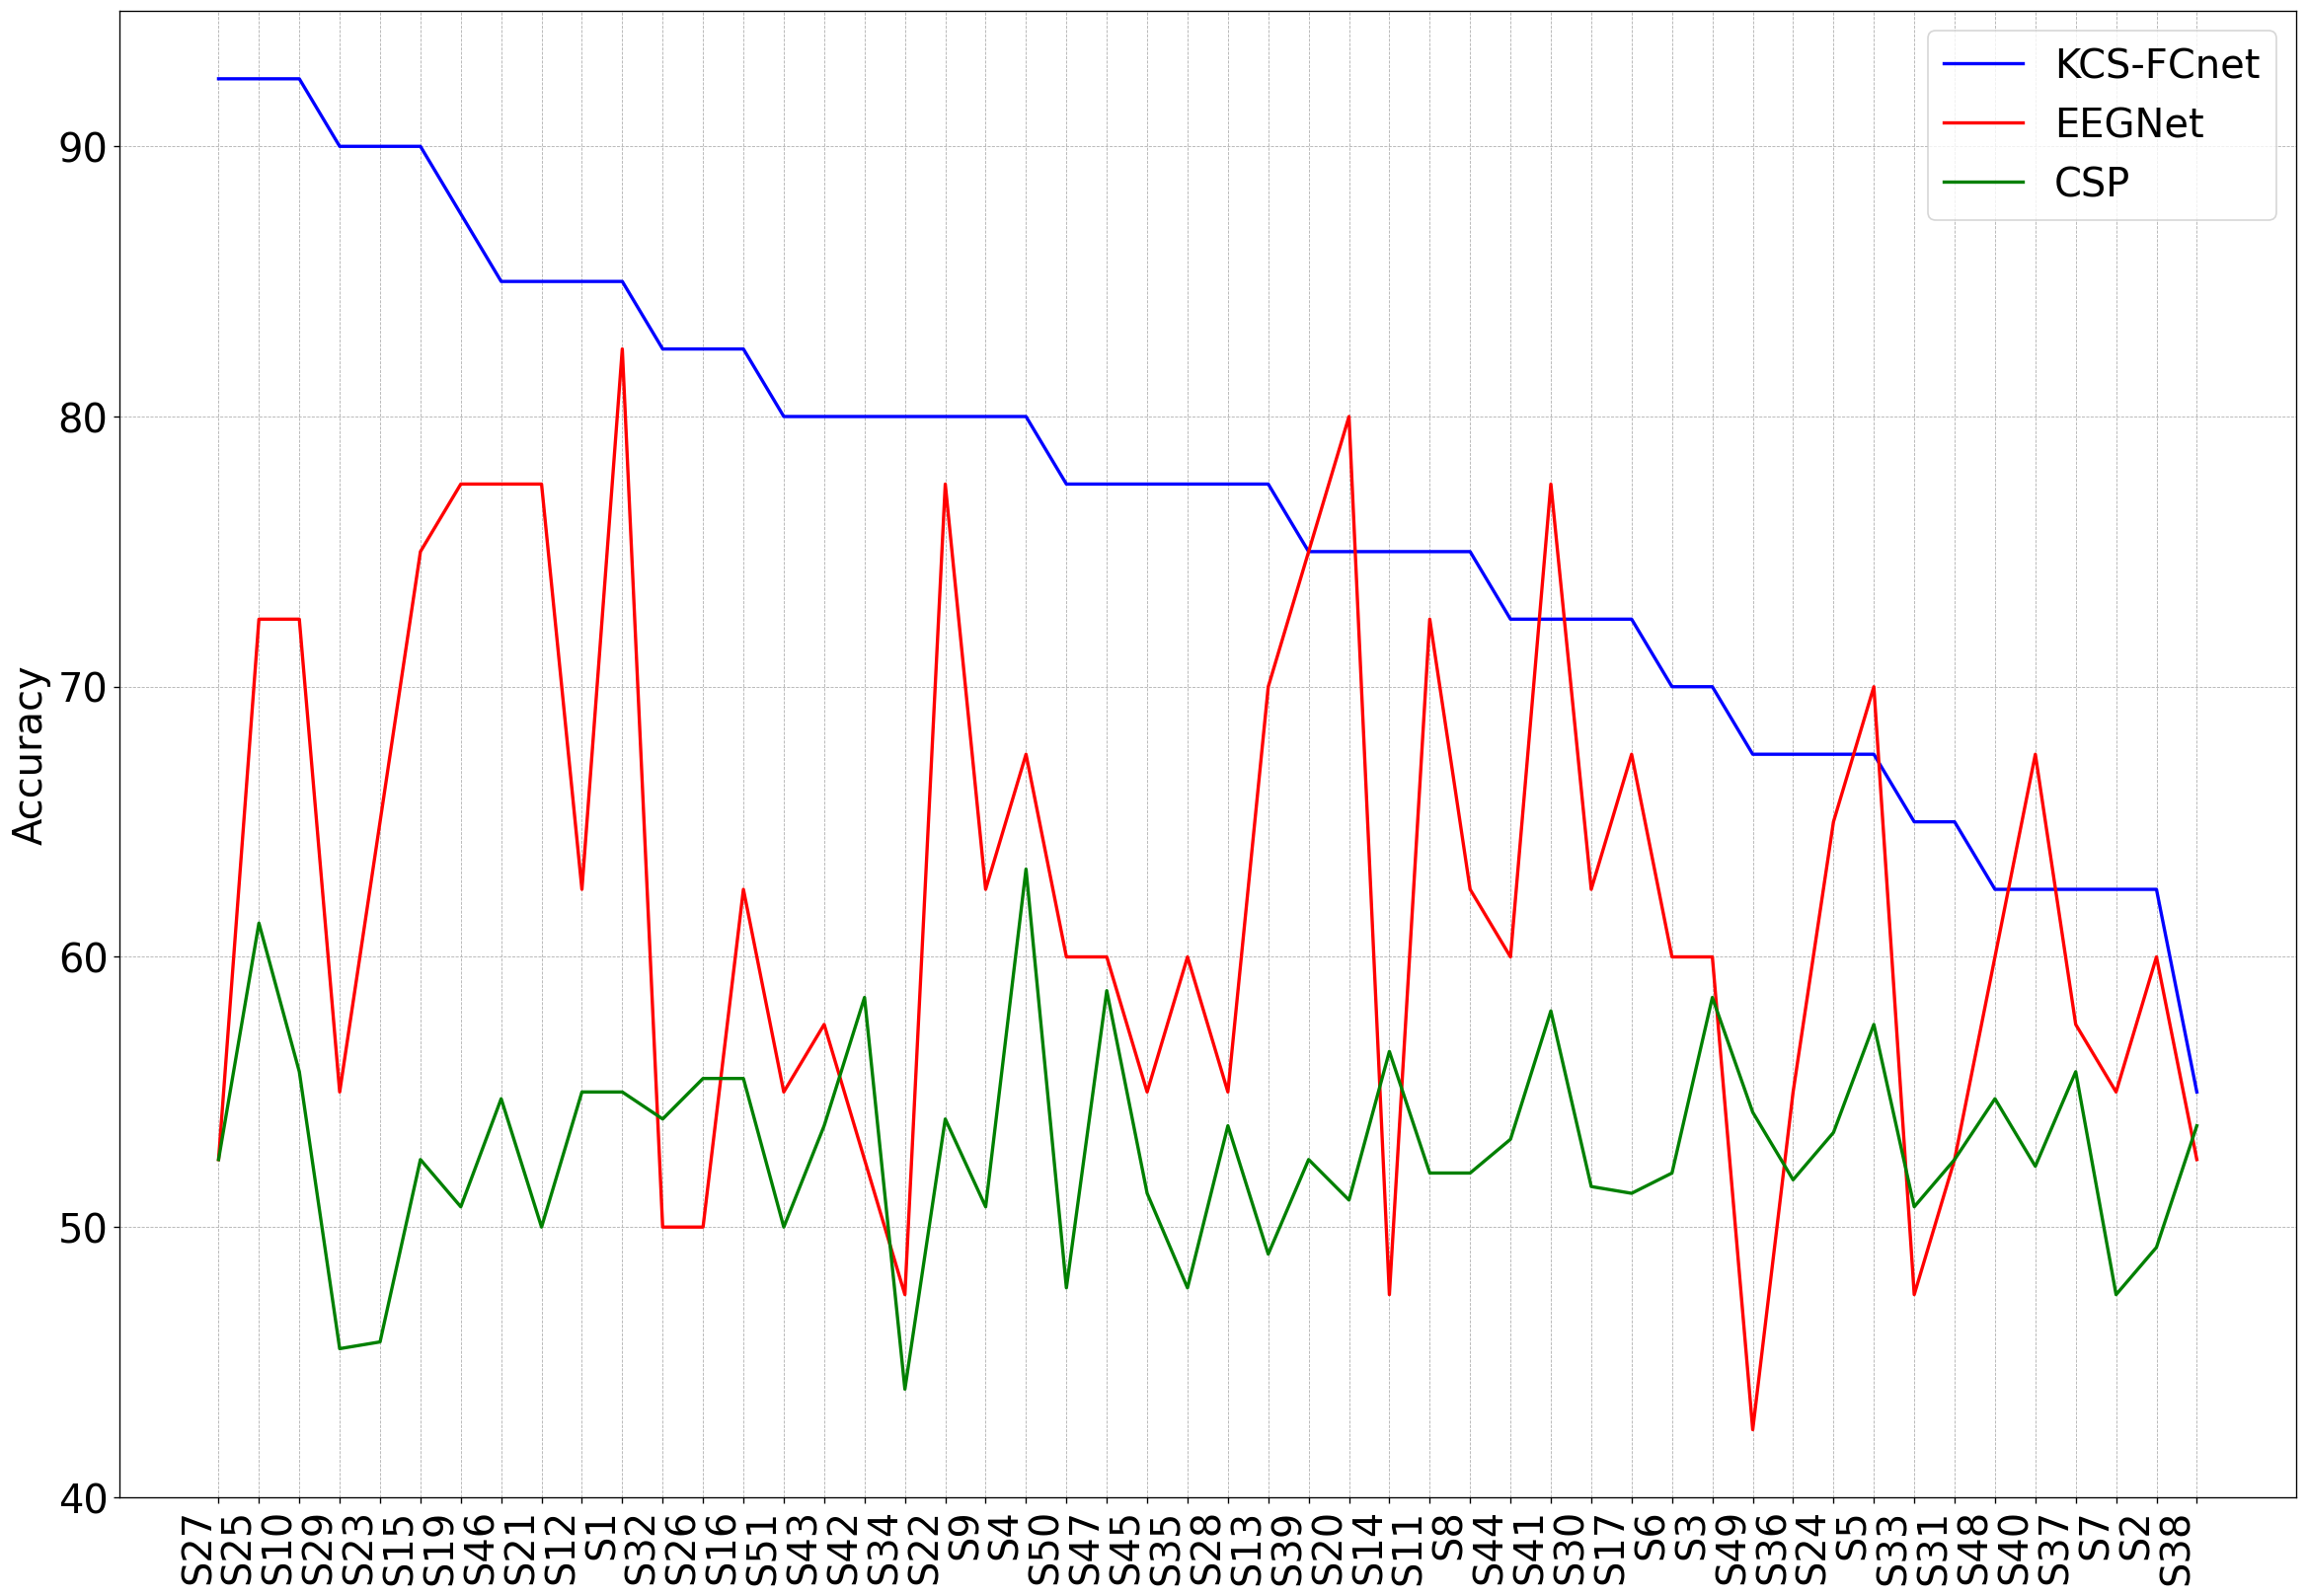

In [29]:
thicks_ = [f'S{score[1]}' for score in ordScores]
gfc_accs = [score[0]*100 for score in ordScores]
eegnet_accs = [score[0]*100 for score in sorted_eegnet_acc_comp]
csp_accs = [score[0]*100 for score in sorted_csp_acc_comp]

plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(20, 14), dpi=120)
# plt.plot(np.arange(1, len(thicks_) + 1, 1), gfc_accs, marker='o', color='b', label='KCS-FCnet', linewidth=2, markersize=6)
# plt.plot(np.arange(1, len(thicks_) + 1, 1), eegnet_accs, marker='s', color='r', label='EEGNet', linewidth=2, markersize=6)
# plt.plot(np.arange(1, len(thicks_) + 1, 1), csp_accs, marker='s', color='g', label='CSP', linewidth=2, markersize=6)
plt.plot(np.arange(1, len(thicks_) + 1, 1), gfc_accs, color='b', label='KCS-FCnet', linewidth=2, markersize=6)
plt.plot(np.arange(1, len(thicks_) + 1, 1), eegnet_accs, color='r', label='EEGNet', linewidth=2, markersize=6)
plt.plot(np.arange(1, len(thicks_) + 1, 1), csp_accs, color='g', label='CSP', linewidth=2, markersize=6)

# X-axis ticks and rotation
plt.xticks(np.arange(1, len(thicks_) + 1, 1), thicks_, rotation=90, ha='right')

# Y-axis label
plt.ylabel('Accuracy')

# Title
# plt.title('Accuracy Comparison between KCS-FCnet and EEGNet Models', fontsize=16)

# Grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Display
plt.tight_layout()
plt.savefig('KCSGFCNetvEEGNetvCSPNoGainL1L2_NotMarker' + ".pdf", format='pdf')
plt.show()

In [30]:
gfc_dict_ = {index: score for score, index, _, _ in acc_compl1l2}

# Sorting eegnet_acc_comp by the order of indices in ordScores
sorted_gfc_acc_comp__ = [(gfc_dict_.get(idx, None), idx) for _, idx, _, _ in ordScores if idx in gfc_dict_]

# print(sorted_eegnet_acc_comp)

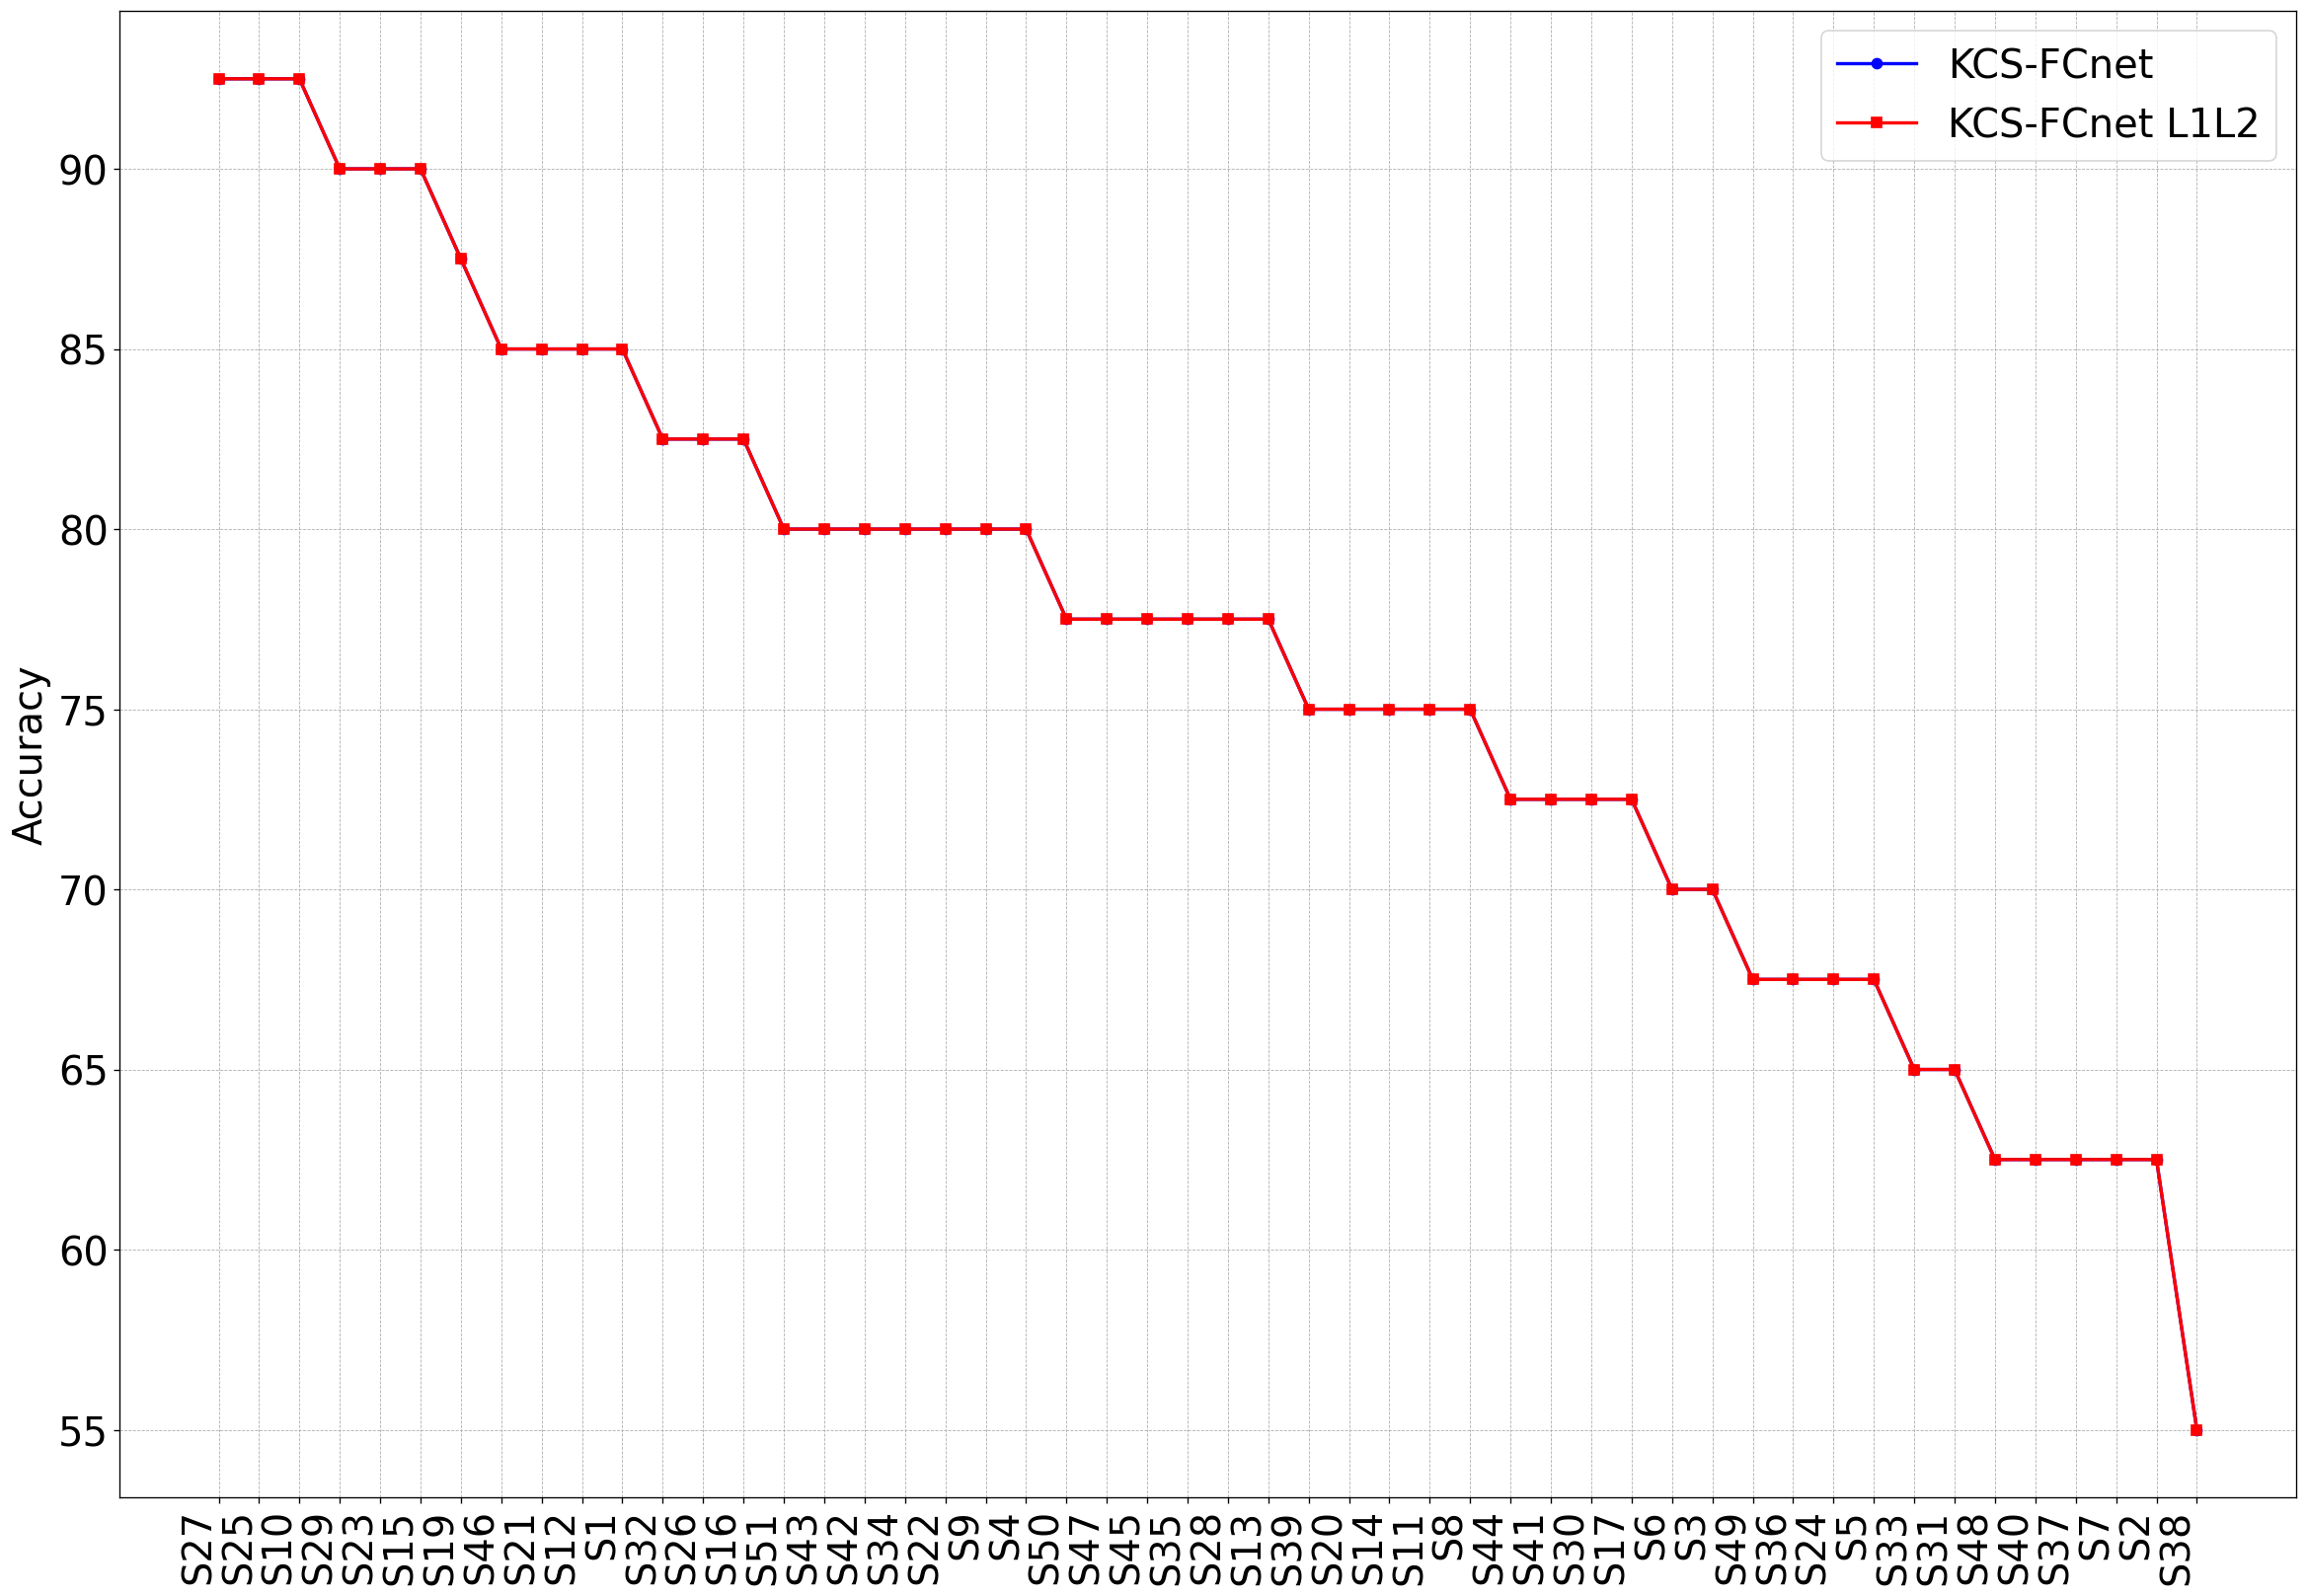

In [32]:
thicks_ = [f'S{score[1]}' for score in ordScores]
gfc_accs = [score[0]*100 for score in ordScores]
gfc_accsl1l2 = [score[0]*100 for score in sorted_gfc_acc_comp__]

plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(20, 14), dpi=120)
plt.plot(np.arange(1, len(thicks_) + 1, 1), gfc_accs, marker='o', color='b', label='KCS-FCnet', linewidth=2, markersize=6)
plt.plot(np.arange(1, len(thicks_) + 1, 1), gfc_accsl1l2, marker='s', color='r', label='KCS-FCnet L1L2', linewidth=2, markersize=6)
# plt.plot(np.arange(1, len(thicks_) + 1, 1), csp_accs, marker='s', color='g', label='CSP', linewidth=2, markersize=6)

# X-axis ticks and rotation
plt.xticks(np.arange(1, len(thicks_) + 1, 1), thicks_, rotation=90, ha='right')

# Y-axis label
plt.ylabel('Accuracy')

# Title
# plt.title('Accuracy Comparison between KCS-FCnet and EEGNet Models', fontsize=16)

# Grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Display
plt.tight_layout()
#plt.savefig('KCSGFCNetvKCSGFCNetL1L2' + ".png")
plt.show()

### CSP

In [ ]:
cspOrdScores = multi_sort(csp_acc_comp)[0]

[(0.6325000000000001, 4),
 (0.6125, 25),
 (0.5875000000000001, 47),
 (0.5850000000000002, 3),
 (0.5850000000000001, 42),
 (0.5799999999999998, 41),
 (0.5750000000000001, 5),
 (0.5650000000000001, 14),
 (0.5575, 10),
 (0.5574999999999999, 37),
 (0.5549999999999999, 26),
 (0.5549999999999999, 16),
 (0.55, 12),
 (0.55, 1),
 (0.5475000000000001, 48),
 (0.5475000000000001, 46),
 (0.5425000000000001, 49),
 (0.54, 32),
 (0.54, 22),
 (0.5375, 43),
 (0.5375, 38),
 (0.5375, 28),
 (0.5349999999999999, 24),
 (0.5325, 44),
 (0.525, 39),
 (0.525, 31),
 (0.525, 27),
 (0.525, 15),
 (0.5225000000000001, 40),
 (0.52, 8),
 (0.52, 6),
 (0.5199999999999999, 11),
 (0.5175000000000001, 36),
 (0.515, 30),
 (0.5125000000000001, 17),
 (0.5125, 45),
 (0.51, 20),
 (0.5075000000000001, 33),
 (0.5075000000000001, 19),
 (0.5075000000000001, 9),
 (0.5, 21),
 (0.4999999999999999, 51),
 (0.4925, 2),
 (0.49000000000000005, 13),
 (0.47750000000000004, 35),
 (0.4774999999999999, 50),
 (0.475, 7),
 (0.4575, 23),
 (0.454999

In [34]:
eegnet_dict = {index: score for score, index, _, _ in eegnet_acc_comp}

# Sorting eegnet_acc_comp by the order of indices in ordScores
sorted_eegnet_acc_comp = [(eegnet_dict.get(idx, None), idx) for _, idx in cspOrdScores if idx in eegnet_dict]

In [35]:
gfcnet_dict = {index: score for score, index, _, _ in acc_comp}

# Sorting eegnet_acc_comp by the order of indices in ordScores
sorted_gfcnet_acc_comp = [(gfcnet_dict.get(idx, None), idx) for _, idx in cspOrdScores if idx in gfcnet_dict]

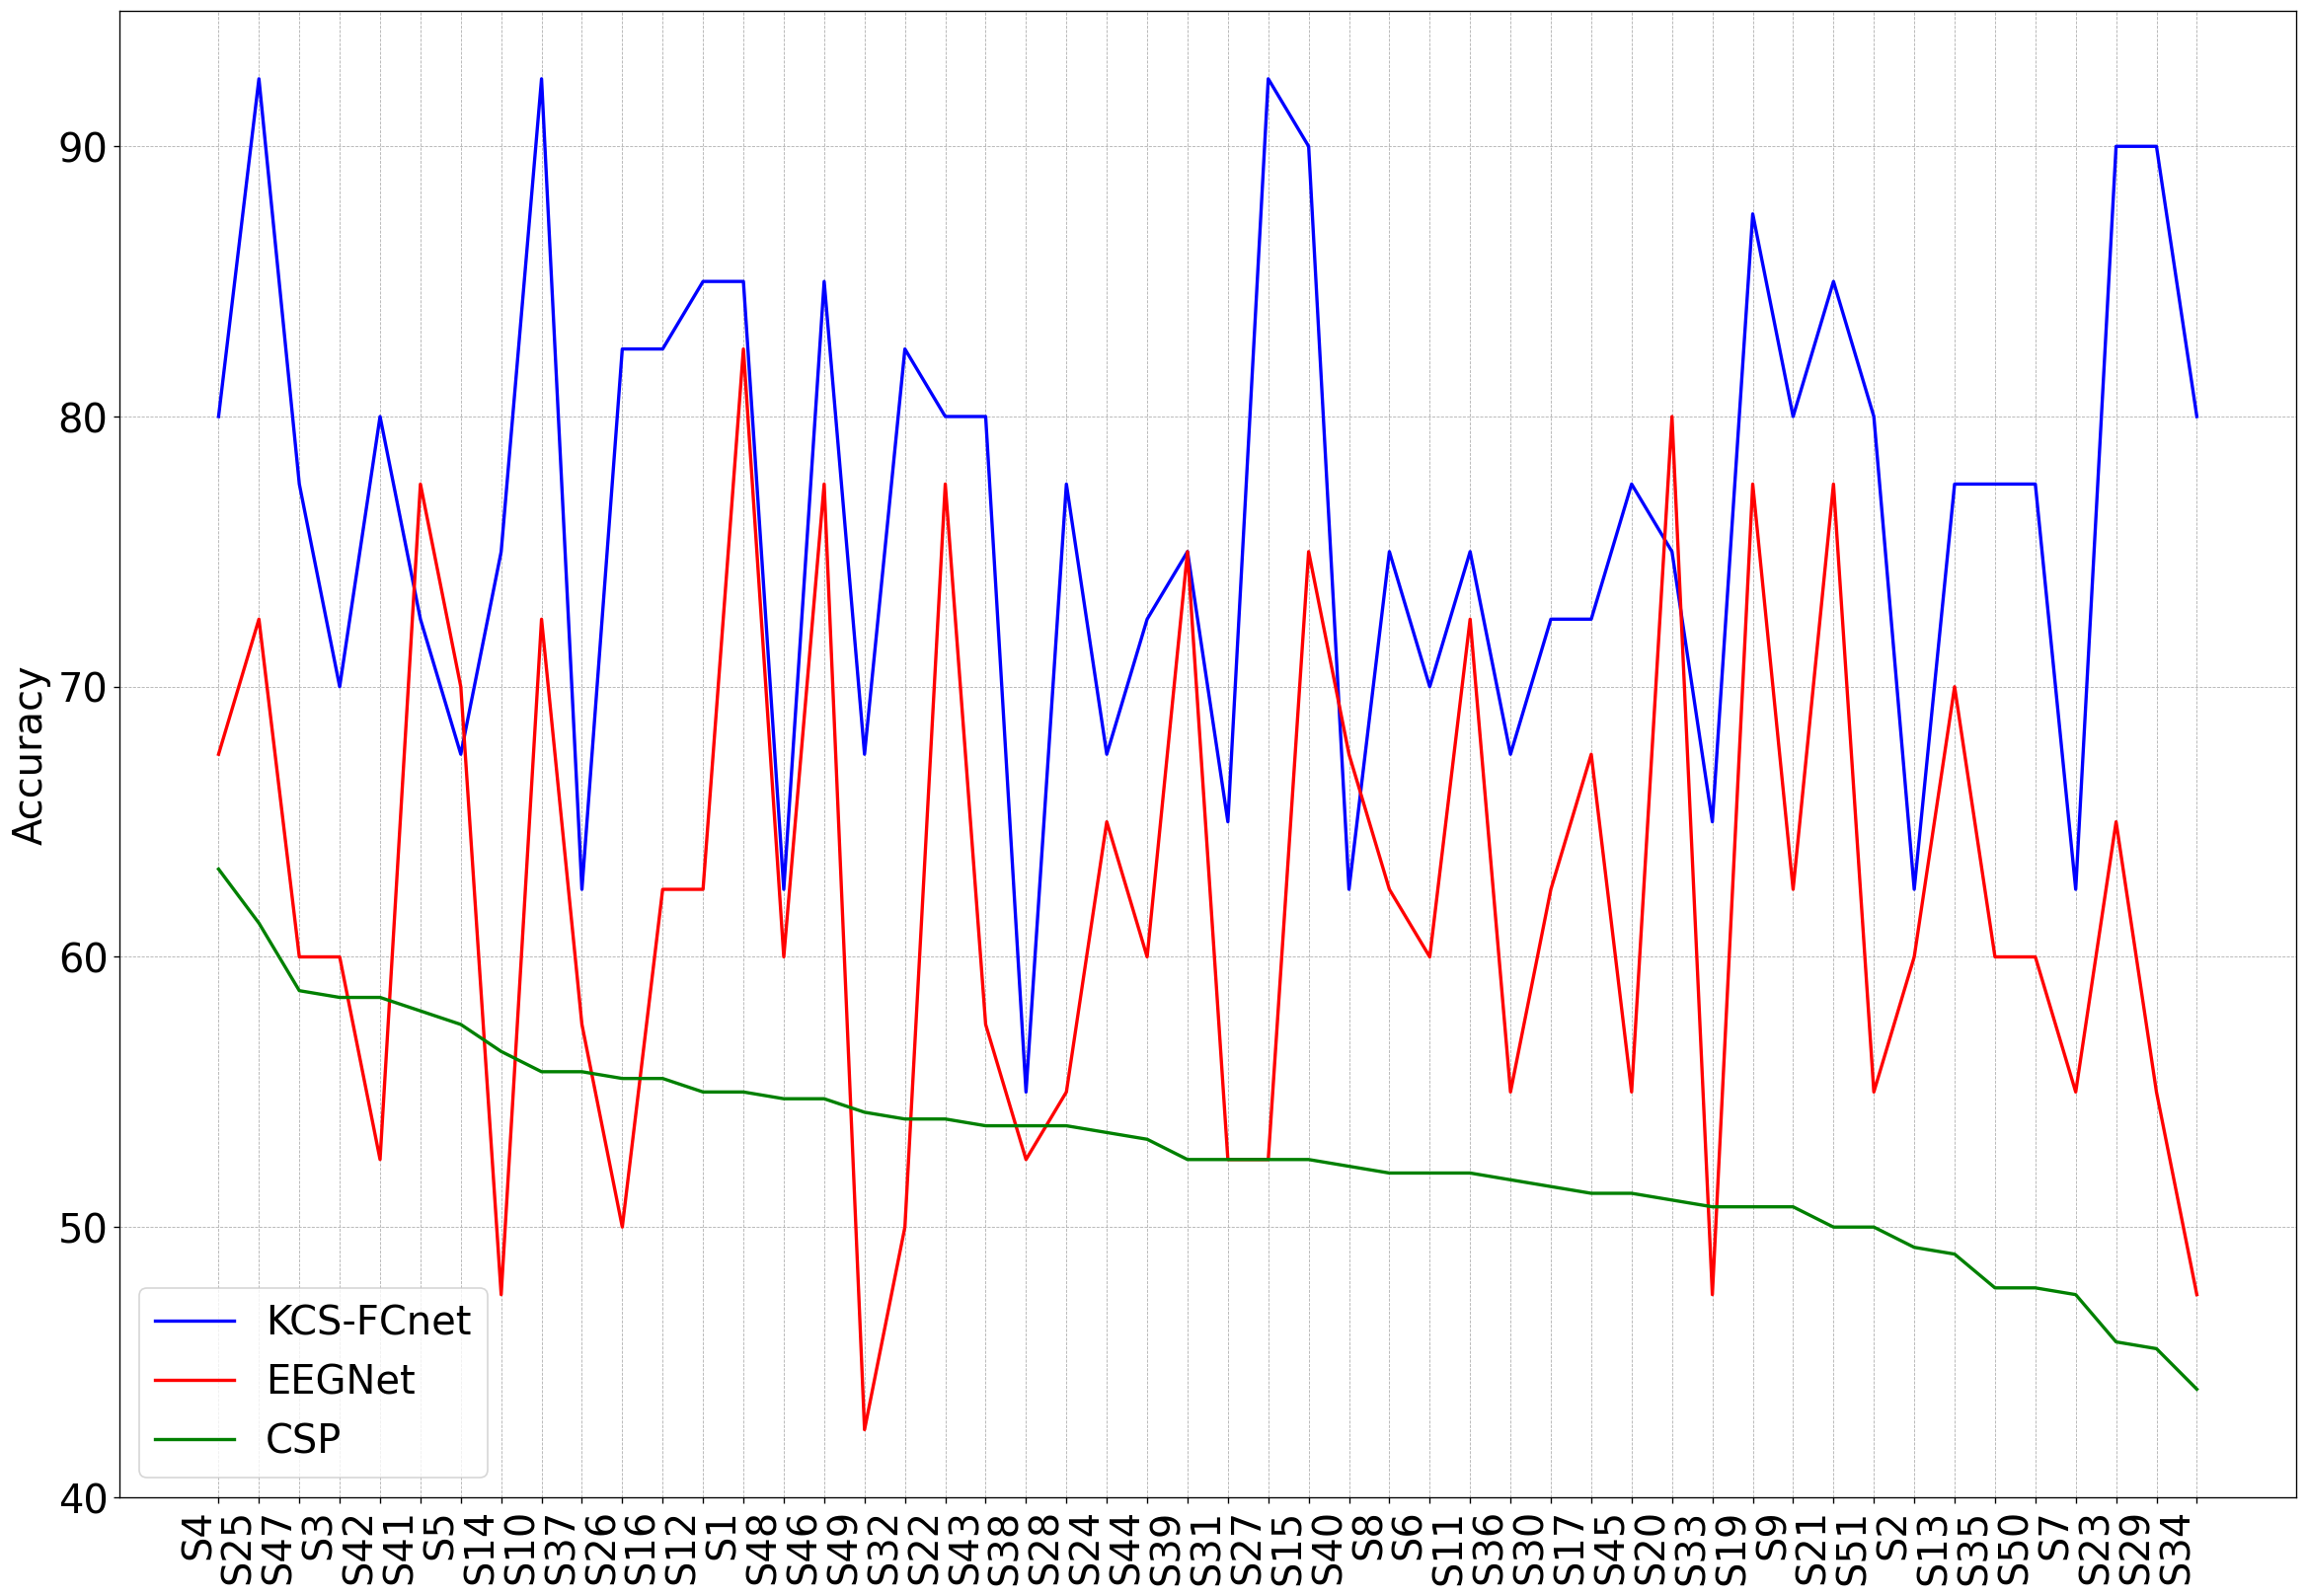

In [ ]:
thicks_ = [f'S{score[1]}' for score in cspOrdScores]
gfc_accs = [score[0]*100 for score in sorted_gfcnet_acc_comp]
eegnet_accs = [score[0]*100 for score in sorted_eegnet_acc_comp]
csp_accs = [score[0]*100 for score in cspOrdScores]

plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(20, 14), dpi=120)
plt.plot(np.arange(1, len(thicks_) + 1, 1), gfc_accs, color='b', label='KCS-FCnet', linewidth=2, markersize=6)
plt.plot(np.arange(1, len(thicks_) + 1, 1), eegnet_accs, color='r', label='EEGNet', linewidth=2, markersize=6)
plt.plot(np.arange(1, len(thicks_) + 1, 1), csp_accs, color='g', label='CSP', linewidth=2, markersize=6)

# X-axis ticks and rotation
plt.xticks(np.arange(1, len(thicks_) + 1, 1), thicks_, rotation=90, ha='right')

# Y-axis label
plt.ylabel('Accuracy')

# Grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Display
plt.tight_layout()
plt.savefig('KCSGFCNetvEEGNetvCSPNoGain_OrdByCSPNoDot' + ".pdf", format='pdf')
plt.show()

### Subject Out

In [38]:
FILEID = "1k1O_FH8d7vmKN37I4Qdj1fBT-hGlYaaN"

contents = os.listdir(os.getcwd())

if 'KCSFCnetMotorLoso85.zip' not in contents:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O KCSFCnetMotorLoso85.zip && rm -rf /tmp/cookies.txt
    !unzip KCSFCnetMotorLoso85.zip

--2024-12-19 03:30:34--  https://docs.google.com/uc?export=download&confirm=&id=1k1O_FH8d7vmKN37I4Qdj1fBT-hGlYaaN
Resolving docs.google.com (docs.google.com)... 172.253.117.101, 172.253.117.113, 172.253.117.100, ...
Connecting to docs.google.com (docs.google.com)|172.253.117.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1k1O_FH8d7vmKN37I4Qdj1fBT-hGlYaaN&export=download [following]
--2024-12-19 03:30:34--  https://drive.usercontent.google.com/download?id=1k1O_FH8d7vmKN37I4Qdj1fBT-hGlYaaN&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38039 (37K) [application/octet-stream]
Saving to: 'KCSFCnetMotorLoso85.zip'

KCSFCnetMotorLoso85 100%[===================>]  37

In [ ]:
import shutil
FILEID = "1RPgZDZP1x79Lcl6-6A7WcFDKSX90q_z3"

contents = os.listdir(os.getcwd())

if 'EEGNetMotorLoso85.zip' not in contents:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O EEGNetMotorLoso85.zip && rm -rf /tmp/cookies.txt
    !unzip EEGNetMotorLoso85.zip

--2024-12-19 03:31:13--  https://docs.google.com/uc?export=download&confirm=&id=1RPgZDZP1x79Lcl6-6A7WcFDKSX90q_z3
Resolving docs.google.com (docs.google.com)... 172.253.117.138, 172.253.117.101, 172.253.117.139, ...
Connecting to docs.google.com (docs.google.com)|172.253.117.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1RPgZDZP1x79Lcl6-6A7WcFDKSX90q_z3&export=download [following]
--2024-12-19 03:31:13--  https://drive.usercontent.google.com/download?id=1RPgZDZP1x79Lcl6-6A7WcFDKSX90q_z3&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26113 (26K) [application/octet-stream]
Saving to: 'EEGNetMotorLoso85.zip'

EEGNetMotorLoso85.z 100%[===================>]  25.5

In [40]:
import shutil
FILEID = "1D5YAVn8jP89jRzfqdPPFddkcluNJe3FJ"

contents = os.listdir(os.getcwd())
folder = 'FBCSPMotorLosoGender'

try:
    os.makedirs(folder)
except:
    pass

if 'FBCSPMotorLosoGenderLast.zip' not in contents:
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O FBCSPMotorLosoGenderLast.zip && rm -rf /tmp/cookies.txt
    !unzip FBCSPMotorLosoGenderLast.zip
    contents = os.listdir()
    for content in contents:
        if content == 'Males' or content == 'Females':
            shutil.move(os.path.join(os.getcwd(), content), os.path.join(os.getcwd(), folder,content))

--2024-12-19 03:31:26--  https://docs.google.com/uc?export=download&confirm=&id=1D5YAVn8jP89jRzfqdPPFddkcluNJe3FJ
Resolving docs.google.com (docs.google.com)... 172.253.117.102, 172.253.117.139, 172.253.117.101, ...
Connecting to docs.google.com (docs.google.com)|172.253.117.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1D5YAVn8jP89jRzfqdPPFddkcluNJe3FJ&export=download [following]
--2024-12-19 03:31:26--  https://drive.usercontent.google.com/download?id=1D5YAVn8jP89jRzfqdPPFddkcluNJe3FJ&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3293 (3.2K) [application/octet-stream]
Saving to: 'FBCSPMotorLosoGenderLast.zip'

FBCSPMotorLosoGende 100%[===================>

In [ ]:
training_details = {'Females': {'Subjects': [1., 10., 12., 23., 29., 46.]},
                    'Males': {'Subjects': [15., 19., 21., 25., 27.]}}

db = '../input/brain-mediators-of-pain-motor/'

num_class = 2

load_args = dict(db = db,
            f_bank = np.asarray([[4., 60.]]),
            vwt = np.asarray([[0.5,2.5]]),
            new_fs = 500.0)

demo_info = {}

folder = 'GFC_Motor_500_l1l2_6gs'
gender_scores = {}

for gender in list(training_details.keys()):
    demo_info[gender] = {'ages': []}
    gender_scores[gender] = {'acc': []}
    print(np.array(training_details[gender]['Subjects']).astype(int))
    for sbj in training_details[gender]['Subjects']:
        load_args['sbj'] = int(sbj)
        age, sex, fs = load_demoinfo(**load_args)
        demo_info[gender]['ages'].append(age)

        scores_path = os.path.join(os.getcwd(), folder, f'Subject{int(sbj)}.p')
    
        #load scores
        with open(scores_path, 'rb') as f:
            cv = pickle.load(f)
    
        gender_scores[gender]['acc'].append(cv['mean_test_Accuracy'][cv['best_index_']])
    
    print(f"{gender}:")
    print(f'Mean Acc: {np.mean(gender_scores[gender]["acc"])} +- {np.std(gender_scores[gender]["acc"])}')

[ 1 10 12 23 29 46]
Females:
Mean Acc: 0.8791666666666665 +- 0.03033379120533552
[15 19 21 25 27]
Males:
Mean Acc: 0.8949999999999999 +- 0.02915475947422653


In [43]:
training_details = {'Females': {'Subjects': [1., 10., 12., 23., 29., 46.]},
                    'Males': {'Subjects': [15., 19., 21., 25., 27.]}}

genders = ['Females', 'Males']

results = {}

for gender in genders:
    gender_subs = training_details[gender]['Subjects']

    for sbj in gender_subs:
        scores_path = os.path.join(os.getcwd(), 'GFC_Motor_500_l1l2_6gs', f'Subject{int(sbj)}.p')
    
        #load scores
        with open(scores_path, 'rb') as f:
            cv = pickle.load(f)
        # print(cv['params'][cv['best_index_']]['filters'], cv['params'][cv['best_index_']]['kernel_time_1'])

In [44]:
training_details = {'Females': {'Subjects': [1., 10., 12., 23., 29., 46.]},
                    'Males': {'Subjects': [15., 19., 21., 25., 27.]}}

genders = ['Females', 'Males']

results = {}

for gender in genders:
    scores_path = os.path.join(os.getcwd(), 'KCSFCnetMotorLoso85', gender, f'KCSFCnetl1l285_{gender}.p')
    
    #load scores
    with open(scores_path, 'rb') as f:
        cv = pickle.load(f)
    best_index = cv['best_index_']
    print(gender)
    print(cv['mean_test_Accuracy'][best_index]*100)
    print(cv['std_test_Accuracy'][best_index]*100)
    print(cv['mean_test_Kappa'][best_index]*100)
    print(cv['std_test_Kappa'][best_index]*100)
    print(cv['mean_test_AUC'][best_index]*100)
    print(cv['std_test_AUC'][best_index]*100)
    results[gender] = {}
    for idx, sbj in enumerate(training_details[gender]['Subjects']):
        best_index = cv['best_index_']
        acc = cv[f'split{idx}_test_Accuracy'][best_index]
        kappa = cv[f'split{idx}_test_Kappa'][best_index]
        auc = cv[f'split{idx}_test_AUC'][best_index]
        results[gender][int(sbj)] = {'Accuracy': acc, 'StdAccuracy': np.std(acc),
                                     'Kappa': kappa, 'StdKappa': np.std(kappa),
                                     'AUC': auc, 'StdAUC': np.std(auc)}

Females
67.50000000000001
14.068285846778444
35.0
28.13657169355689
80.91666666666666
18.359640216760482
Males
80.81578947368422
6.4096101670128744
61.63157894736842
12.819220334025747
90.8567867036011
7.794795747617663


In [45]:
genders = ['Females', 'Males']

eegnet_results = {}

for gender in genders:
    scores_path = os.path.join(os.getcwd(), 'EEGNetMotorLoso85', gender, f'EEGNetl1l285_{gender}.p')
    
    #load scores
    with open(scores_path, 'rb') as f:
        cv = pickle.load(f)

    print(gender)
    print(cv['mean_test_Accuracy'][best_index]*100)
    print(cv['std_test_Accuracy'][best_index]*100)
    print(cv['mean_test_Kappa'][best_index]*100)
    print(cv['std_test_Kappa'][best_index]*100)
    print(cv['mean_test_AUC'][best_index]*100)
    print(cv['std_test_AUC'][best_index]*100)
    # print(cv.keys())
    eegnet_results[gender] = {}
    for idx, sbj in enumerate(training_details[gender]['Subjects']):
        best_index = cv['best_index_']
        acc = cv[f'split{idx}_test_Accuracy'][best_index]
        kappa = cv[f'split{idx}_test_Kappa'][best_index]
        auc = cv[f'split{idx}_test_AUC'][best_index]
        eegnet_results[gender][int(sbj)] = {'Accuracy': acc, 'StdAccuracy': np.nanstd(acc),
                                     'Kappa': kappa, 'StdKappa': np.nanstd(kappa),
                                     'AUC': auc, 'StdAUC': np.nanstd(auc)}

Females
63.33333333333334
10.573814617041267
26.666666666666668
21.147629234082533
78.33333333333333
17.902319837260077
Males
77.76315789473685
3.7364714419576512
55.52631578947368
7.4729428839153025
86.52714681440443
3.717831239818328


In [46]:
genders = ['Females', 'Males']

csp_results = {}

for gender in genders:
    scores_path = os.path.join(os.getcwd(), 'FBCSPMotorLosoGender', gender, f'FBCSP_{gender}_Last.p')
    
    #load scores
    with open(scores_path, 'rb') as f:
        cv = pickle.load(f)

    print(gender)
    print(cv['mean_test_acc'][best_index]*100)
    print(cv['std_test_acc'][best_index]*100)
    print(cv['mean_test_kappa'][best_index]*100)
    print(cv['std_test_kappa'][best_index]*100)
    print(cv['mean_test_auc'][best_index]*100)
    print(cv['std_test_auc'][best_index]*100)

    # print(cv)
    csp_results[gender] = {}
    for idx, sbj in enumerate(training_details[gender]['Subjects']):
        best_index = cv['best_index_']
        acc = cv[f'split{idx}_test_acc'][best_index]
        kappa = cv[f'split{idx}_test_kappa'][best_index]
        auc = cv[f'split{idx}_test_auc'][best_index]
        csp_results[gender][int(sbj)] = {'Accuracy': acc, 'StdAccuracy': np.nanstd(acc),
                                     'Kappa': kappa, 'StdKappa': np.nanstd(kappa),
                                     'AUC': auc, 'StdAUC': np.nanstd(auc)}

Females
62.91666666666668
9.061901321221475
25.833333333333336
18.12380264244295
62.91666666666666
9.061901321221475
Males
57.684210526315795
7.830705242718433
15.368421052631579
15.66141048543687
57.684210526315795
7.830705242718432


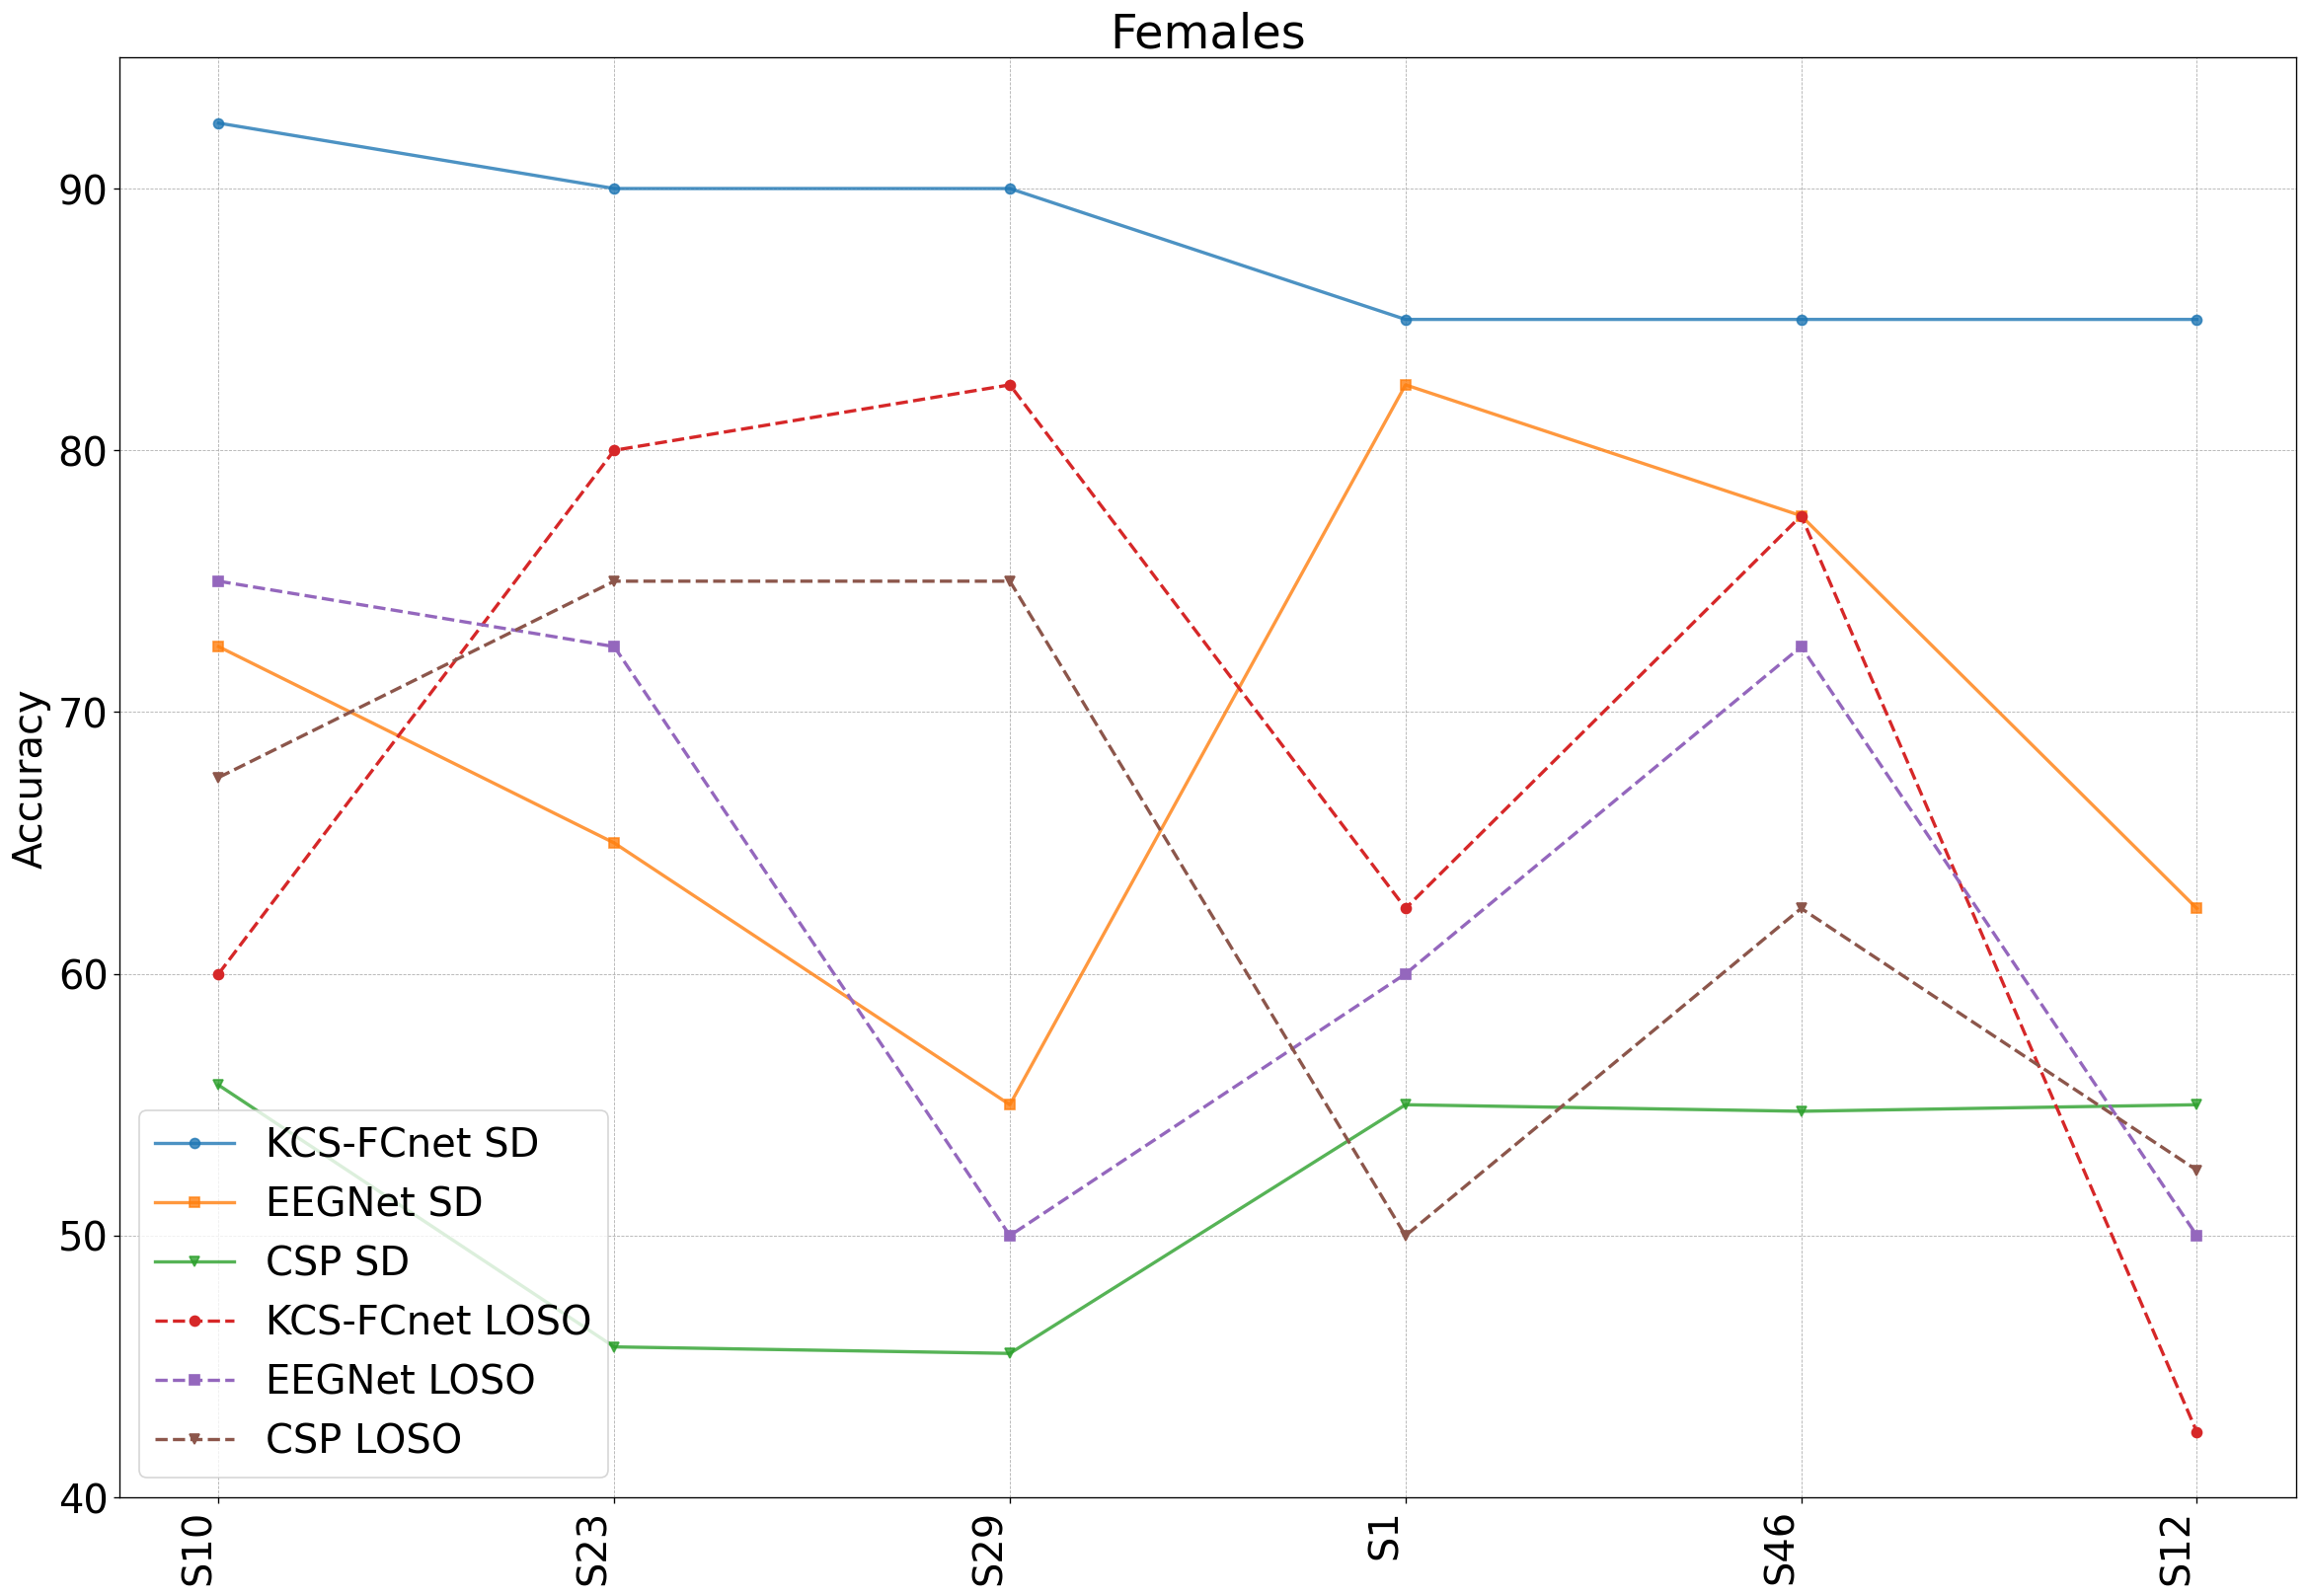

Females:
GFCNet 67.5 +- 14.068285846778442
EEGNet 63.333333333333336 +- 10.573814617041267
FBCSP  63.75 +- 9.868932735272509




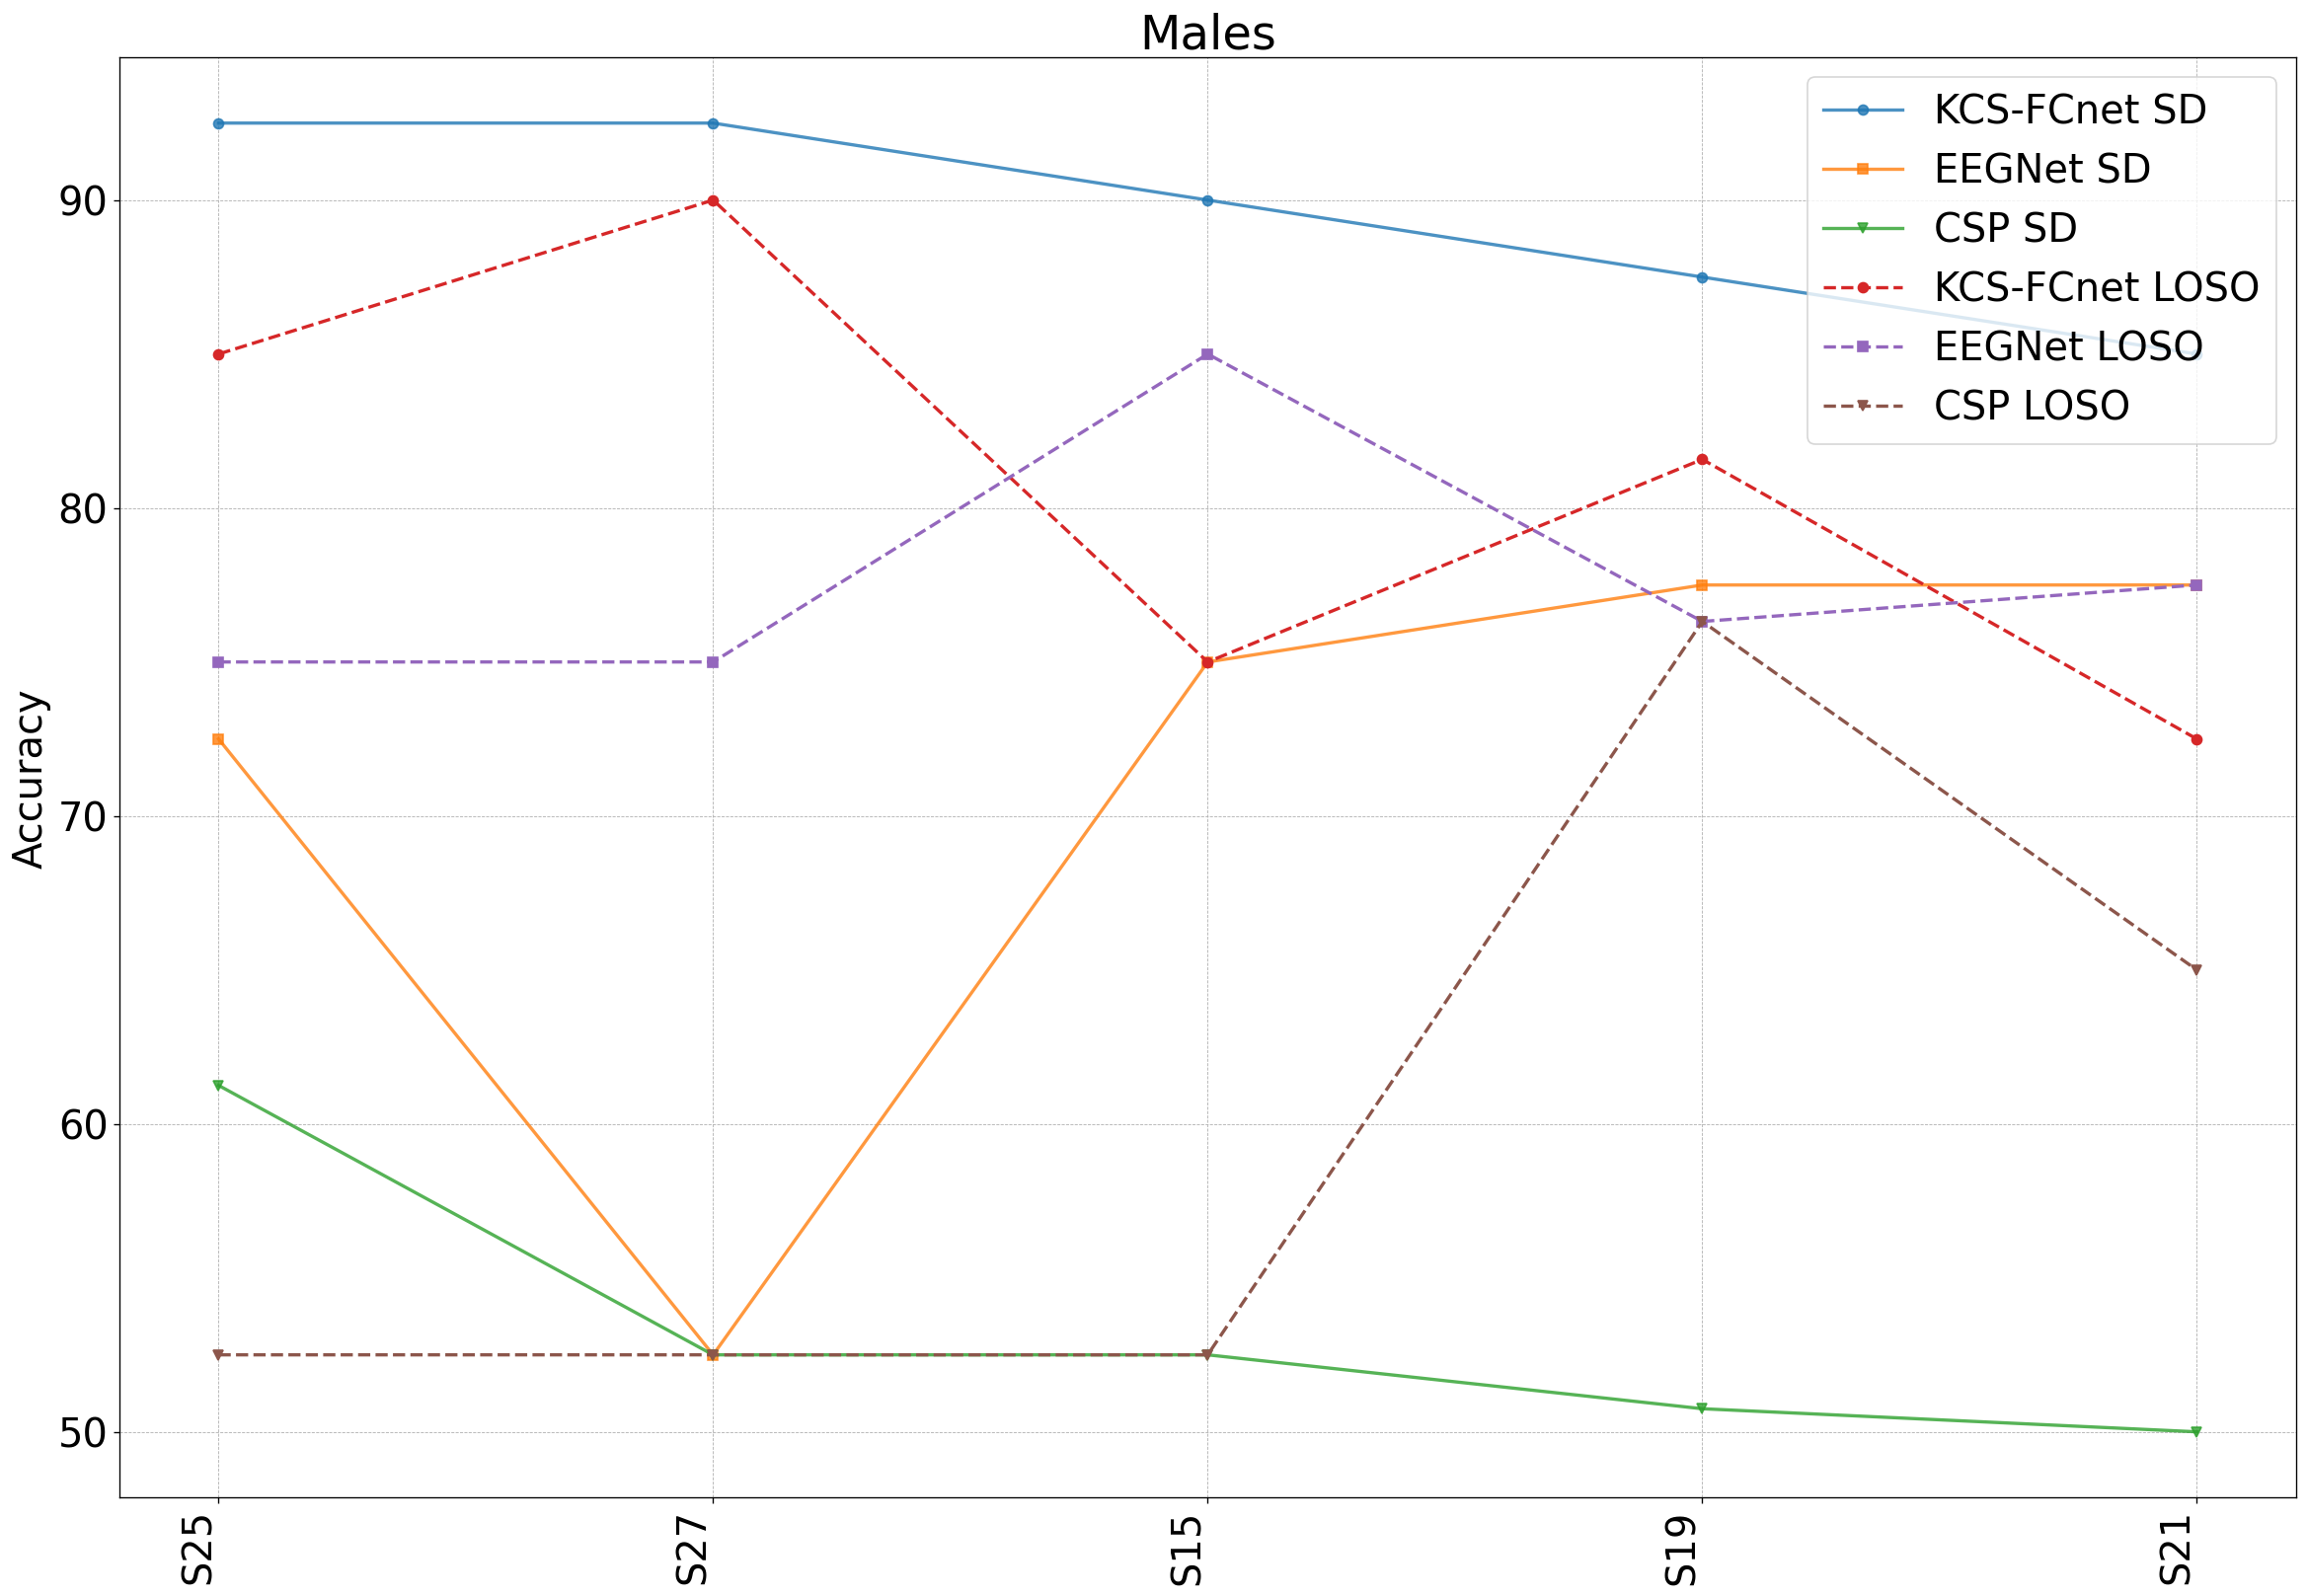

Males:
GFCNet 80.8157894736842 +- 6.409610167012874
EEGNet 77.76315789473685 +- 3.7364714419576512
FBCSP  59.76315789473684 +- 9.588269032890738


General Performance:
GFCNet 74.15789473684211 +- 3.8293378398827844
EEGNet 70.5482456140351 +- 3.4186715875418074
FBCSP  61.756578947368425 +- 0.14033185119088554




In [47]:
plt.rcParams.update({'font.size': 24})

gfc_accs_ = []
eeg_accs_ = []
csp_accs_ = []

gfc_std_accs_ = []
eeg_std_accs_ = []
csp_std_accs_ = []

for gender in genders:
    gfc_accs = [np.mean(results[gender][int(sbj)]['Accuracy'])*100 for sbj in training_details[gender]['Subjects']]
    eegnet_accs = [np.mean(eegnet_results[gender][int(sbj)]['Accuracy'])*100 for sbj in training_details[gender]['Subjects']]
    csp_accs = [np.nanmean(csp_results[gender][int(sbj)]['Accuracy'])*100 for sbj in training_details[gender]['Subjects']]


    gfc_sdep_acc = []
    eegnet_sdep_acc = []
    csp_sdep_acc = []
    for sbj in training_details[gender]['Subjects']:
        scores_path = os.path.join(os.getcwd(), 'GFC_Motor_500_l1l2_6gs', f'Subject{int(sbj)}.p')
        with open(scores_path, 'rb') as f:
            cv = pickle.load(f)
        gfc_sdep_acc.append(cv['mean_test_Accuracy'][cv['best_index_']]*100)

        scores_full_path = os.path.join(os.getcwd(), 'EEGNet_Motor_500Hz_60Hz', f'Subject{int(sbj)}.p')
        with open(scores_full_path, 'rb') as f:
            cv = pickle.load(f)
        eegnet_sdep_acc.append(cv['mean_test_Accuracy'][cv['best_index_']]*100)

        sbj_jlib_scores = joblib.load(os.path.join(os.getcwd(), f'CSP500/Subject{int(sbj)}_elastic_featuresCSP.joblib'))
        csp_sdep_acc.append(np.nanmean(sbj_jlib_scores['cv_results']['mean_test_acc'])*100) 
        
    scores_mat = []
    for gfc_sd, eegnet_sd, csp_sd, gfc_loso, eegnet_loso, csp_loso, sbj in zip(gfc_sdep_acc, eegnet_sdep_acc, csp_sdep_acc, gfc_accs, eegnet_accs, csp_accs, training_details[gender]['Subjects']):
        scores_mat.append([gfc_sd, eegnet_sd, csp_sd, gfc_loso, eegnet_loso, csp_loso, sbj])

    sortedSores = multi_sort(scores_mat)[0]

    arr = np.array(sortedSores)

    thicks_ = [f'S{int(sbj)}' for sbj in arr[:,-1]]

    plt.figure(figsize=(20, 14), dpi=120)
    plt.title(f'{gender}')
    plt.plot(np.arange(1, len(thicks_) + 1, 1), arr[:,0], marker='o', label='KCS-FCnet SD', linewidth=2, markersize=6, alpha=0.8)
    plt.plot(np.arange(1, len(thicks_) + 1, 1), arr[:,1], marker='s', label='EEGNet SD', linewidth=2, markersize=6, alpha=0.8)
    plt.plot(np.arange(1, len(thicks_) + 1, 1), arr[:,2], marker='v', label='CSP SD', linewidth=2, markersize=6, alpha=0.8)
    plt.plot(np.arange(1, len(thicks_) + 1, 1), arr[:,3], marker='o', label='KCS-FCnet LOSO', linewidth=2, markersize=6, linestyle='dashed')
    plt.plot(np.arange(1, len(thicks_) + 1, 1), arr[:,4], marker='s', label='EEGNet LOSO', linewidth=2, markersize=6, linestyle='dashed')
    plt.plot(np.arange(1, len(thicks_) + 1, 1), arr[:,5], marker='v', label='CSP LOSO', linewidth=2, markersize=6, linestyle='dashed')

    # X-axis ticks and rotation
    plt.xticks(np.arange(1, len(thicks_) + 1, 1), thicks_, rotation=90, ha='right')
    
    # Y-axis label
    plt.ylabel('Accuracy')
    
    # Title
    # plt.title('Accuracy Comparison between KCS-FCnet and EEGNet Models', fontsize=16)
    
    # Grid and legend
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()

    # Display
    plt.tight_layout()
    # plt.savefig(f'KCSGFCNetvEEGNetvCSP_SD_LOSO_{gender}' + ".png")
    plt.show()

    gfc_accs_.append(np.mean(arr[:,3]))
    eeg_accs_.append(np.mean(arr[:,4]))
    csp_accs_.append(np.mean(arr[:,5]))

    gfc_std_accs_.append(np.std(arr[:,3]))
    eeg_std_accs_.append(np.std(arr[:,4]))
    csp_std_accs_.append(np.std(arr[:,5]))
    
    print(f"{gender}:")
    print(f"GFCNet {np.mean(arr[:,3])} +- {np.std(arr[:,3])}")
    print(f"EEGNet {np.mean(arr[:,4])} +- {np.std(arr[:,4])}")
    print(f"FBCSP  {np.mean(arr[:,5])} +- {np.std(arr[:,5])}\n\n")

print("General Performance:")
print(f"GFCNet {np.mean(gfc_accs_)} +- {np.std(gfc_std_accs_)}")
print(f"EEGNet {np.mean(eeg_accs_)} +- {np.std(eeg_std_accs_)}")
print(f"FBCSP  {np.mean(csp_accs_)} +- {np.std(csp_std_accs_)}\n\n")

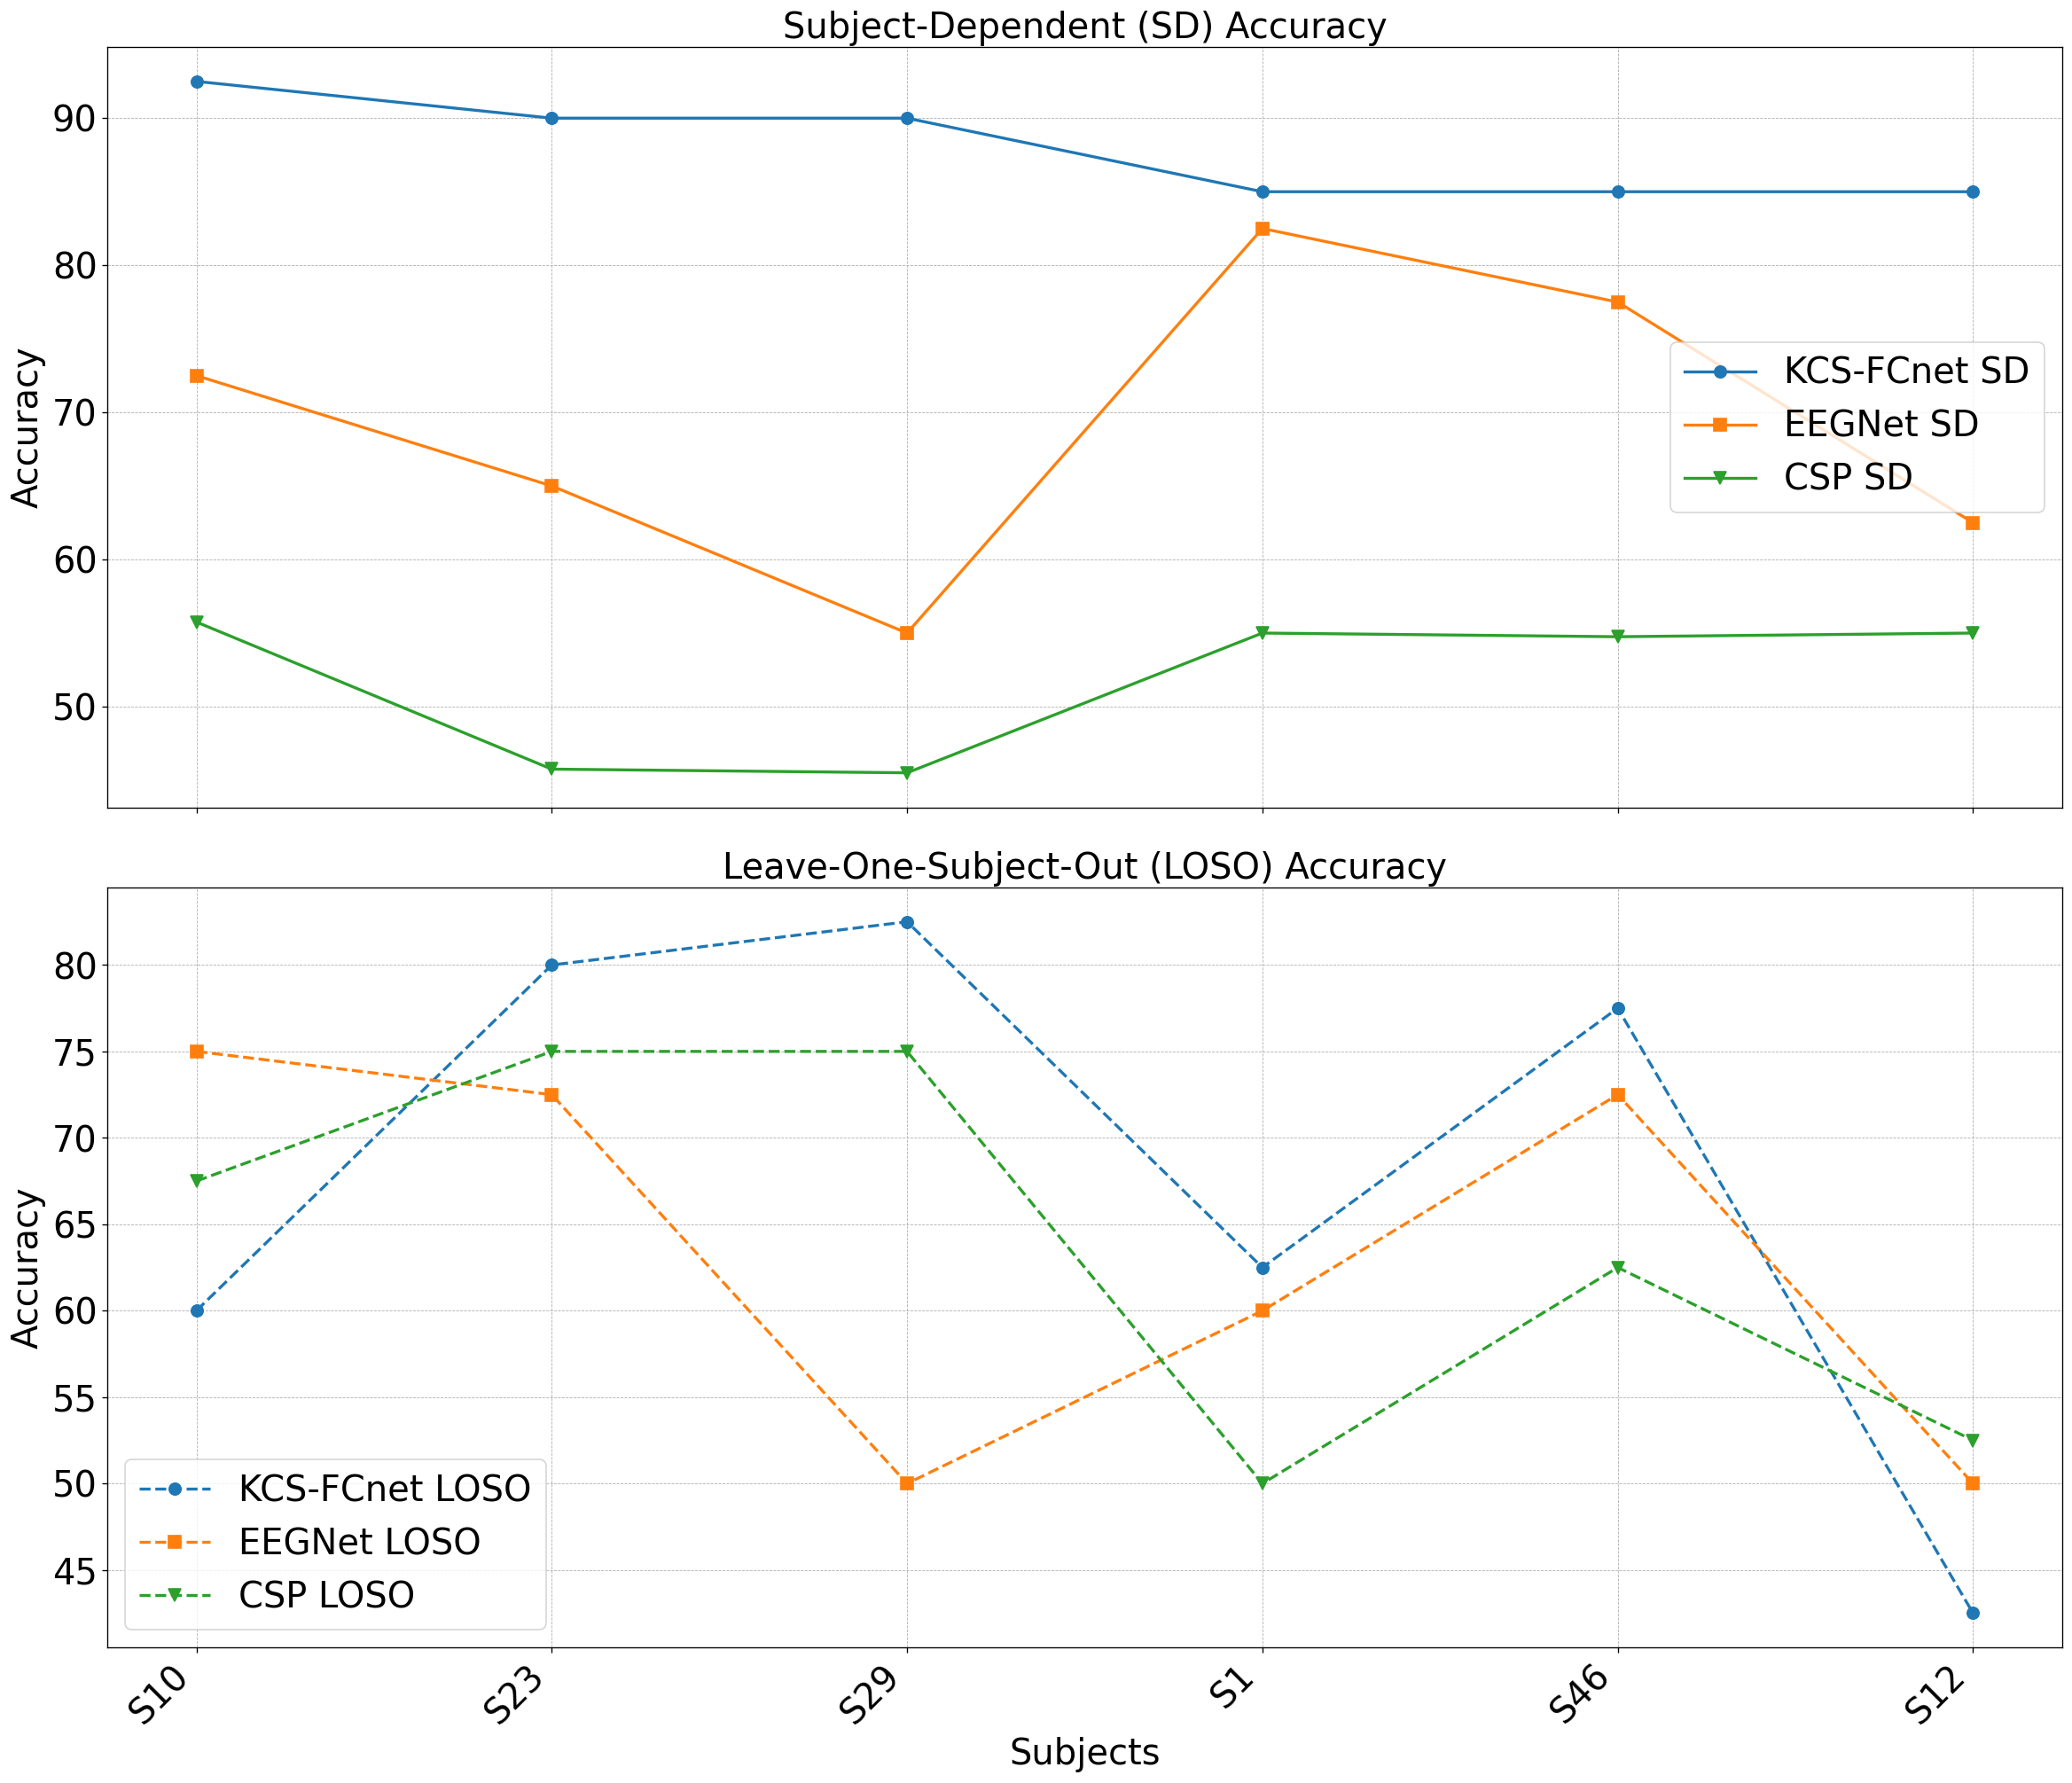

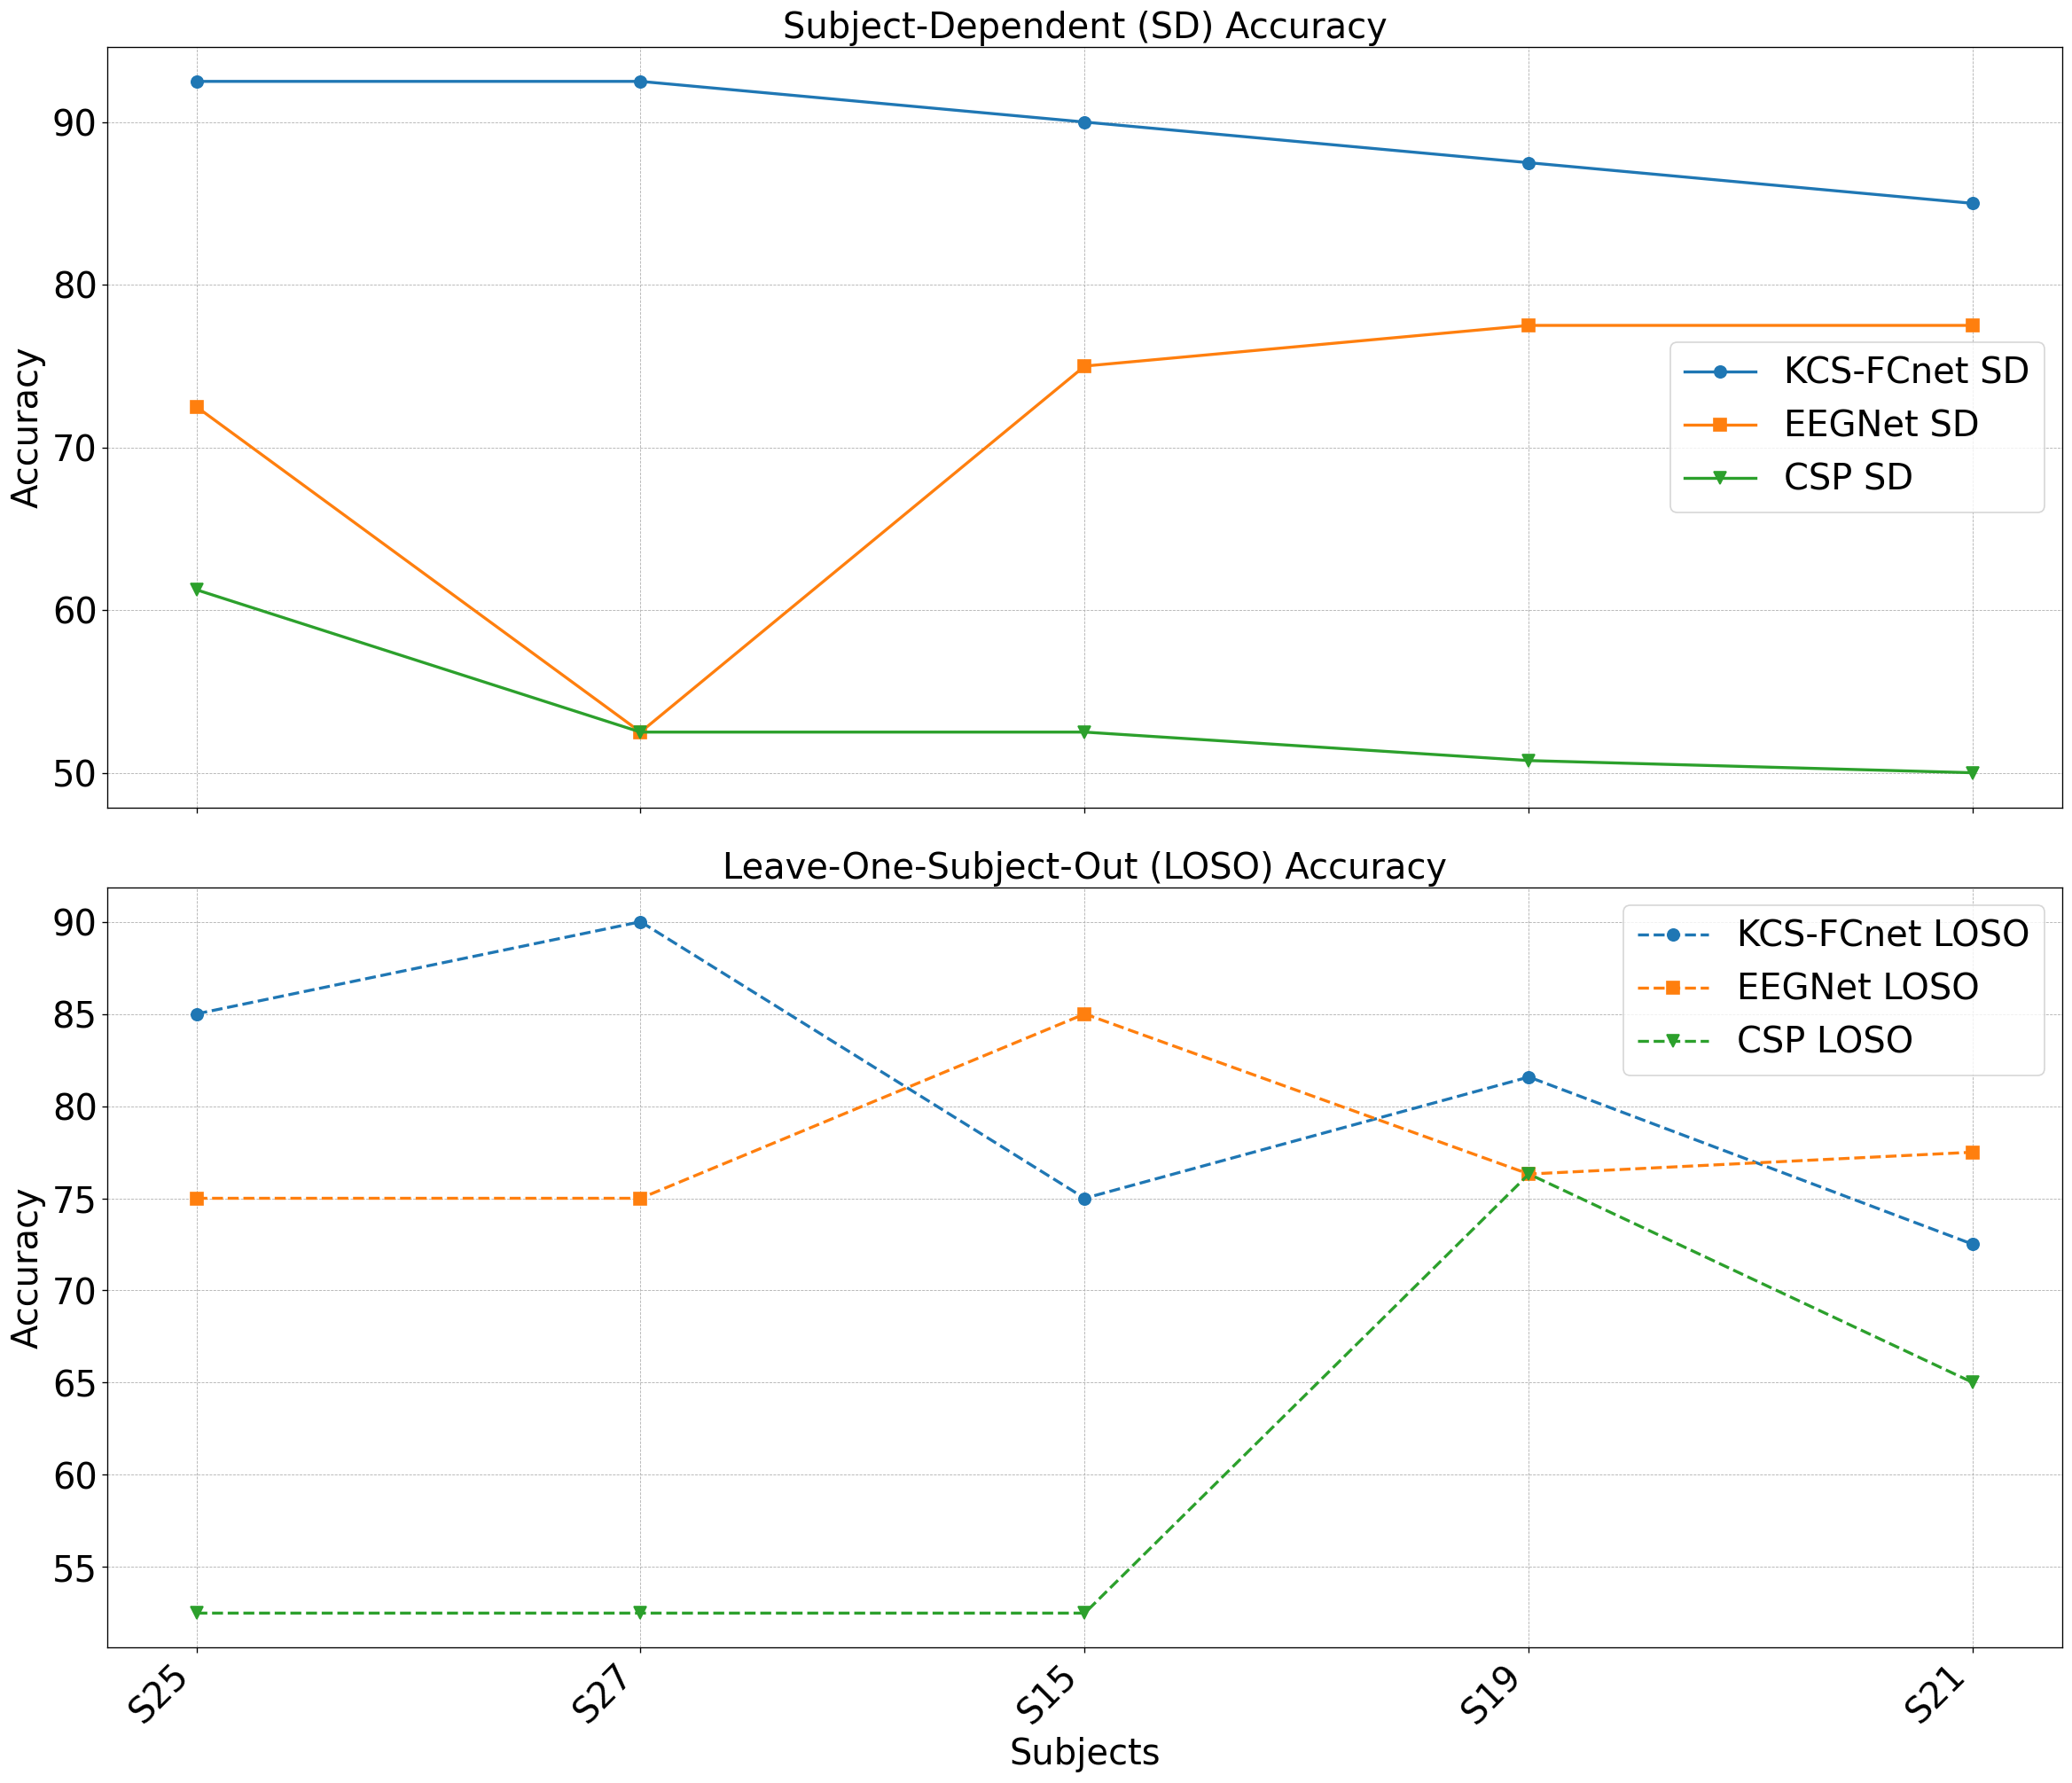

In [49]:
plt.rcParams.update({'font.size': 24})

gfc_accs_ = []
eeg_accs_ = []
csp_accs_ = []

gfc_std_accs_ = []
eeg_std_accs_ = []
csp_std_accs_ = []

for gender in genders:
    gfc_accs = [np.mean(results[gender][int(sbj)]['Accuracy'])*100 for sbj in training_details[gender]['Subjects']]
    eegnet_accs = [np.mean(eegnet_results[gender][int(sbj)]['Accuracy'])*100 for sbj in training_details[gender]['Subjects']]
    csp_accs = [np.nanmean(csp_results[gender][int(sbj)]['Accuracy'])*100 for sbj in training_details[gender]['Subjects']]


    gfc_sdep_acc = []
    eegnet_sdep_acc = []
    csp_sdep_acc = []
    for sbj in training_details[gender]['Subjects']:
        scores_path = os.path.join(os.getcwd(), 'GFC_Motor_500_l1l2_6gs', f'Subject{int(sbj)}.p')
        with open(scores_path, 'rb') as f:
            cv = pickle.load(f)
        gfc_sdep_acc.append(cv['mean_test_Accuracy'][cv['best_index_']]*100)

        scores_full_path = os.path.join(os.getcwd(), 'EEGNet_Motor_500Hz_60Hz', f'Subject{int(sbj)}.p')
        with open(scores_full_path, 'rb') as f:
            cv = pickle.load(f)
        eegnet_sdep_acc.append(cv['mean_test_Accuracy'][cv['best_index_']]*100)

        sbj_jlib_scores = joblib.load(os.path.join(os.getcwd(), f'CSP500/Subject{int(sbj)}_elastic_featuresCSP.joblib'))
        csp_sdep_acc.append(np.nanmean(sbj_jlib_scores['cv_results']['mean_test_acc'])*100) 
        
    scores_mat = []
    for gfc_sd, eegnet_sd, csp_sd, gfc_loso, eegnet_loso, csp_loso, sbj in zip(gfc_sdep_acc, eegnet_sdep_acc, csp_sdep_acc, gfc_accs, eegnet_accs, csp_accs, training_details[gender]['Subjects']):
        scores_mat.append([gfc_sd, eegnet_sd, csp_sd, gfc_loso, eegnet_loso, csp_loso, sbj])

    sortedSores = multi_sort(scores_mat)[0]

    arr = np.array(sortedSores)

    thicks_ = [f'S{int(sbj)}' for sbj in arr[:,-1]]

    fig, axes = plt.subplots(2, 1, figsize=(20, 18), dpi=120, sharex=True)
    
    # SD Plot
    axes[0].plot(np.arange(1, len(thicks_) + 1, 1), arr[:, 0], marker='o', label='KCS-FCnet SD', linewidth=2, markersize=8)
    axes[0].plot(np.arange(1, len(thicks_) + 1, 1), arr[:, 1], marker='s', label='EEGNet SD', linewidth=2, markersize=8)
    axes[0].plot(np.arange(1, len(thicks_) + 1, 1), arr[:, 2], marker='v', label='CSP SD', linewidth=2, markersize=8)
    axes[0].set_title('Subject-Dependent (SD) Accuracy', fontsize=24)
    axes[0].set_ylabel('Accuracy')
    axes[0].grid(True, linestyle='--', linewidth=0.5)
    axes[0].legend()
    
    # LOSO Plot
    axes[1].plot(np.arange(1, len(thicks_) + 1, 1), arr[:, 3], marker='o', label='KCS-FCnet LOSO', linewidth=2, markersize=8, linestyle='dashed')
    axes[1].plot(np.arange(1, len(thicks_) + 1, 1), arr[:, 4], marker='s', label='EEGNet LOSO', linewidth=2, markersize=8, linestyle='dashed')
    axes[1].plot(np.arange(1, len(thicks_) + 1, 1), arr[:, 5], marker='v', label='CSP LOSO', linewidth=2, markersize=8, linestyle='dashed')
    axes[1].set_title('Leave-One-Subject-Out (LOSO) Accuracy', fontsize=24)
    axes[1].set_xlabel('Subjects')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid(True, linestyle='--', linewidth=0.5)
    axes[1].legend()
    
    # Adjust x-axis ticks
    plt.xticks(np.arange(1, len(thicks_) + 1, 1), thicks_, rotation=45, ha='right')
    
    # General title and spacing
    # plt.suptitle(f'{gender} Accuracy Comparison', fontsize=28)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save and display
    plt.savefig(f'Comparison_{gender}_SD_LOSO.pdf', format='pdf', dpi=300)
    plt.show()


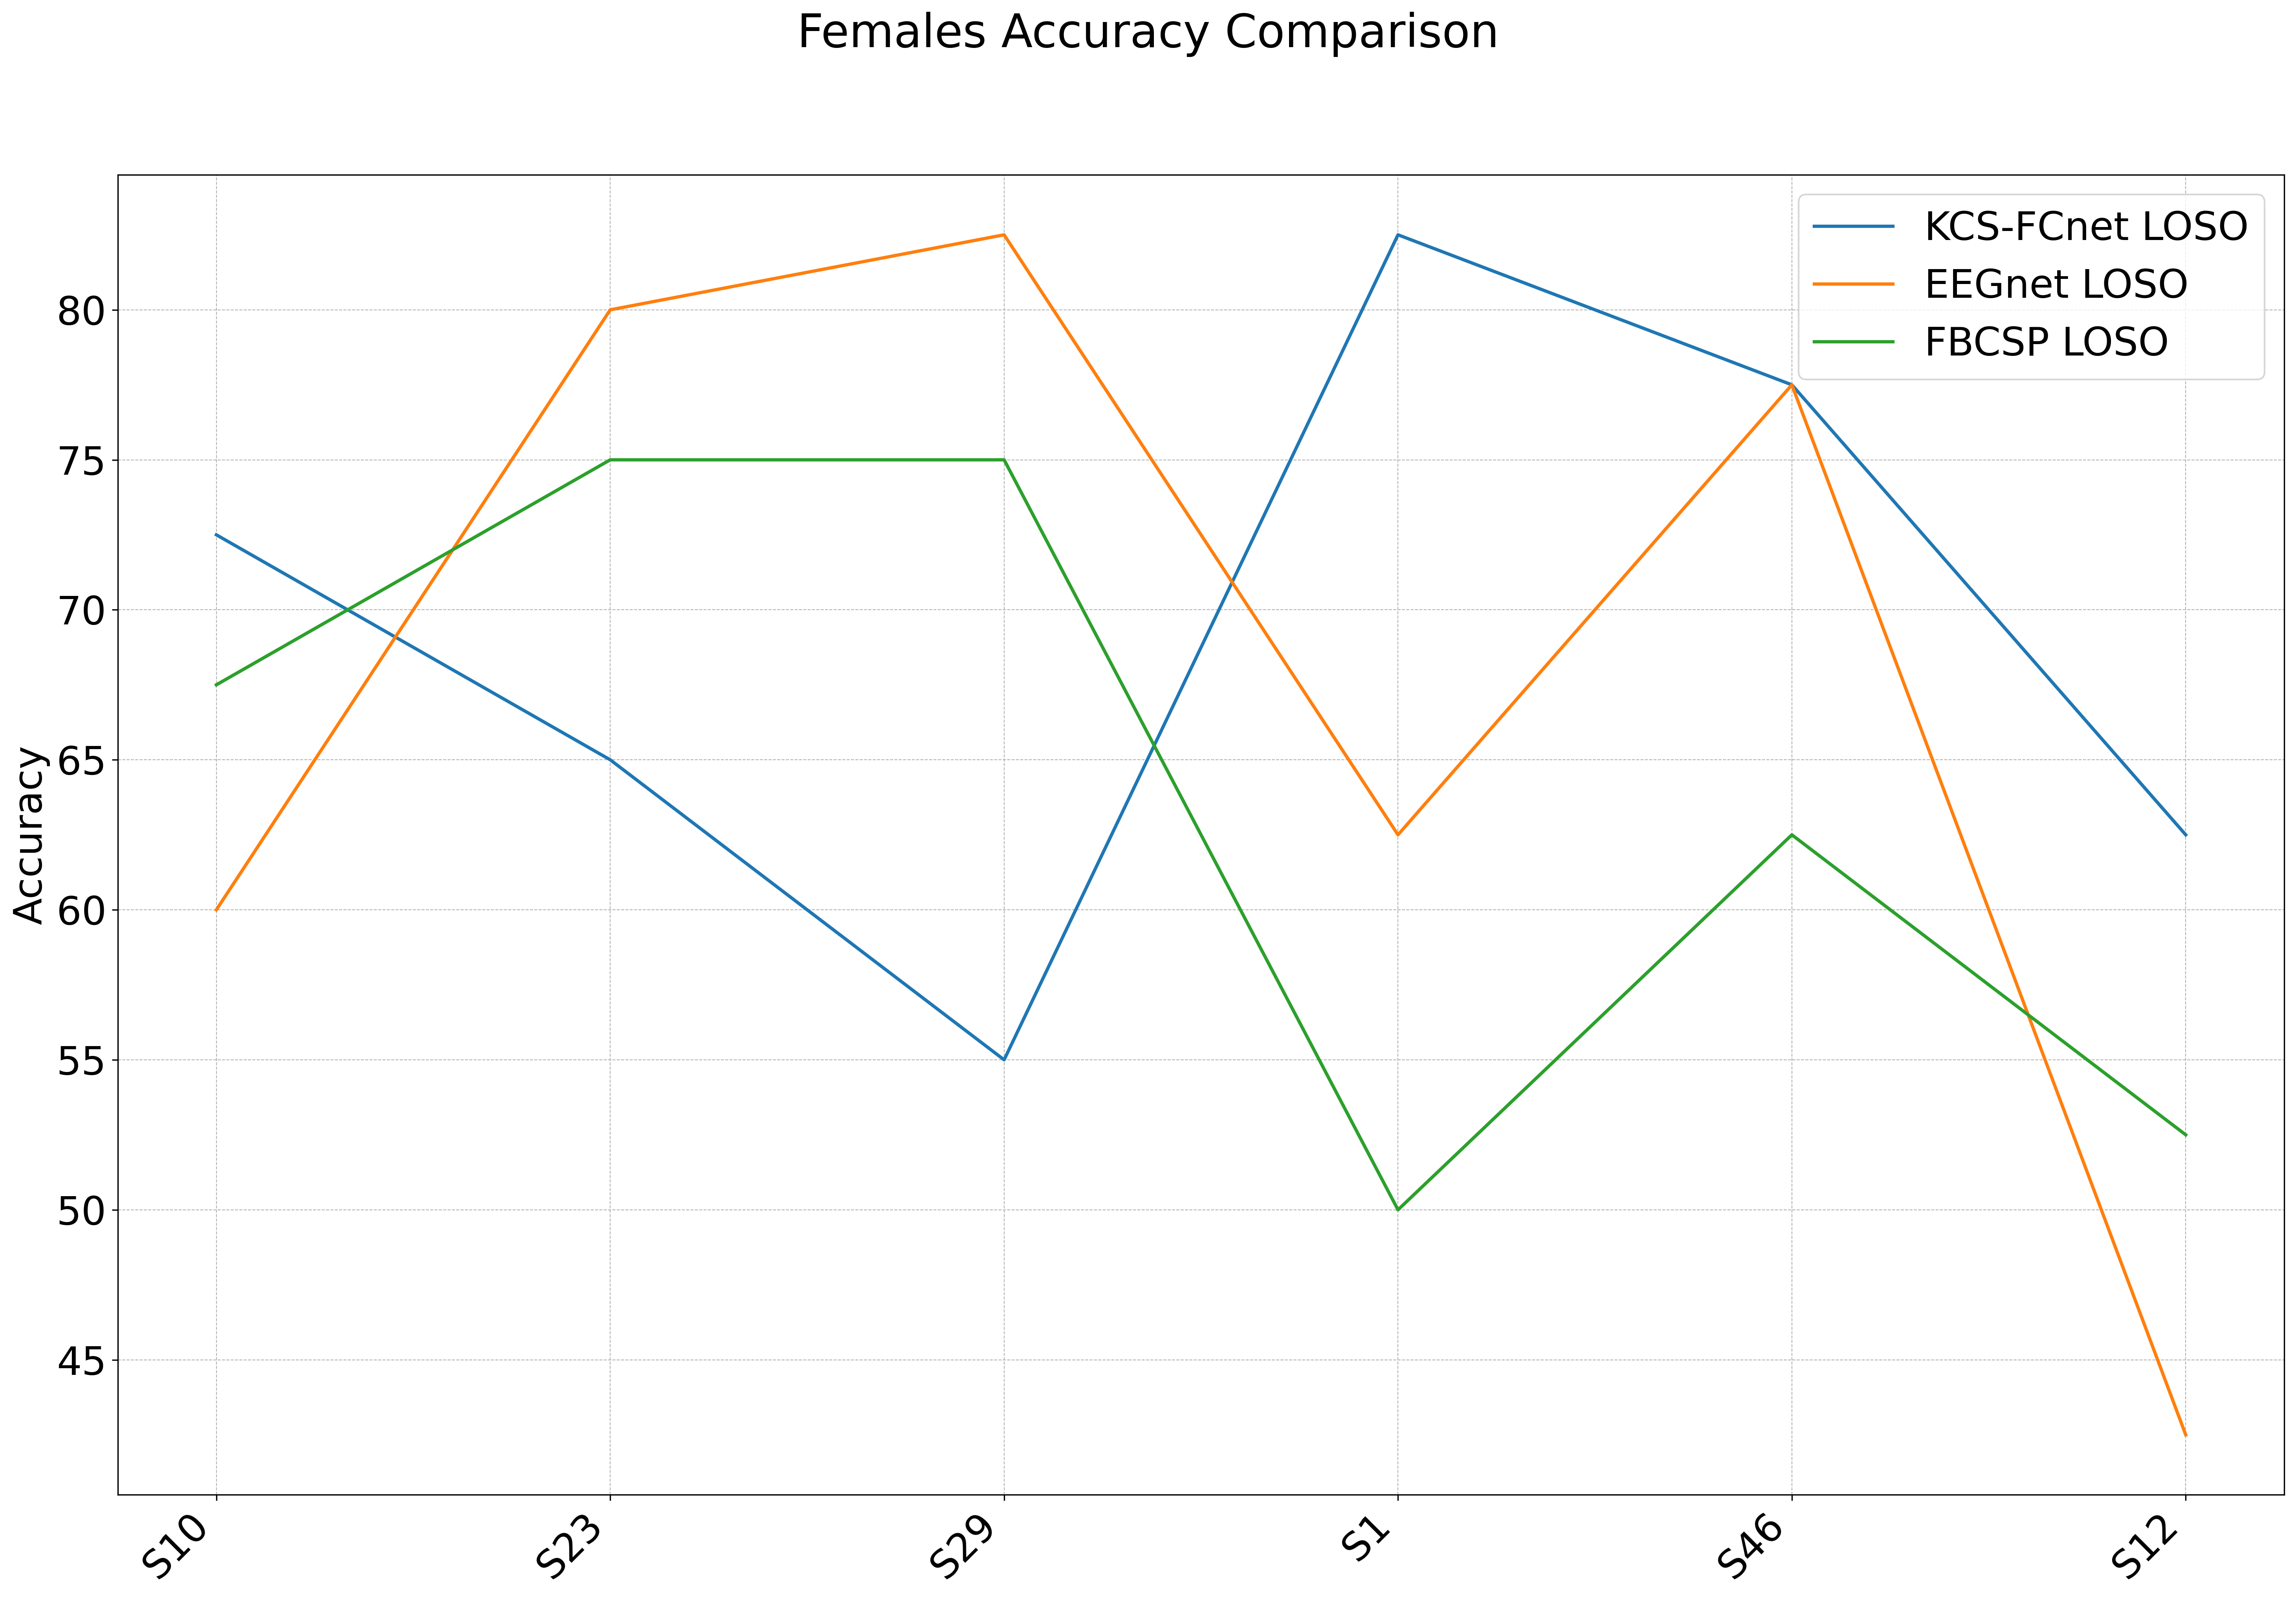

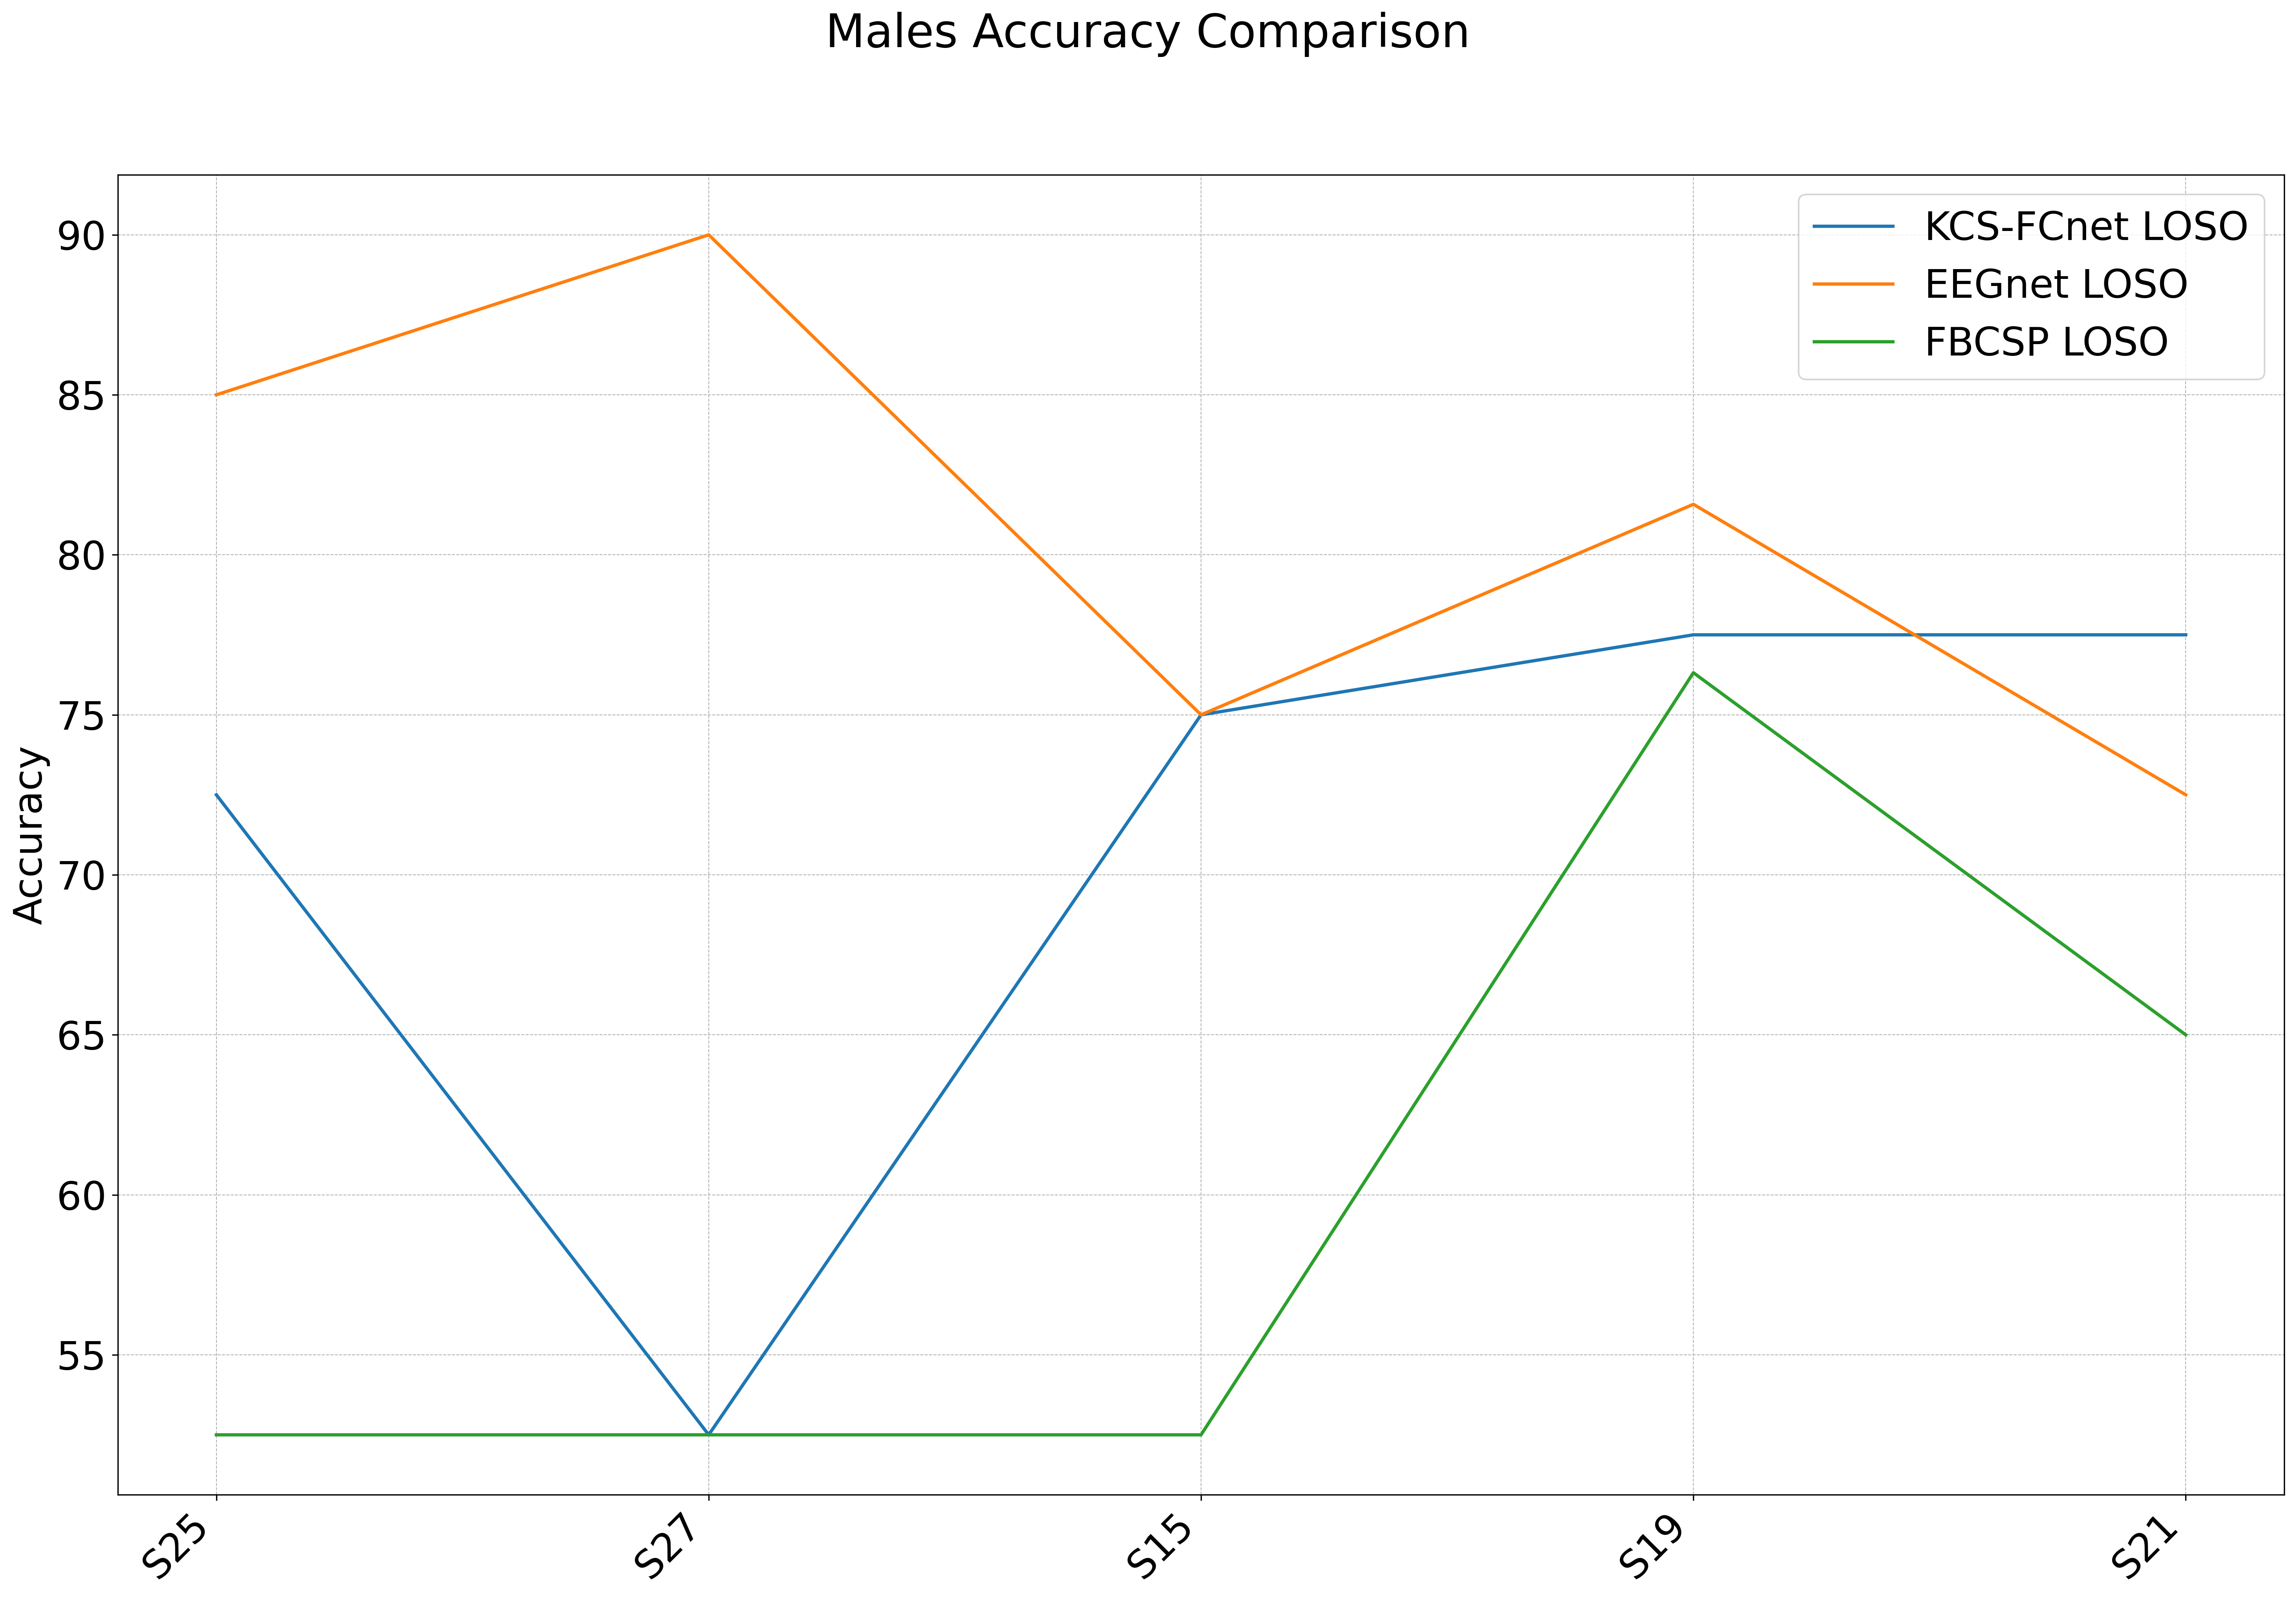

In [38]:
plt.rcParams.update({'font.size': 24})

gfc_accs_ = []
eeg_accs_ = []
csp_accs_ = []

gfc_std_accs_ = []
eeg_std_accs_ = []
csp_std_accs_ = []

for gender in genders:
    gfc_accs = [np.mean(results[gender][int(sbj)]['Accuracy'])*100 for sbj in training_details[gender]['Subjects']]
    eegnet_accs = [np.mean(eegnet_results[gender][int(sbj)]['Accuracy'])*100 for sbj in training_details[gender]['Subjects']]
    csp_accs = [np.nanmean(csp_results[gender][int(sbj)]['Accuracy'])*100 for sbj in training_details[gender]['Subjects']]


    gfc_sdep_acc = []
    eegnet_sdep_acc = []
    csp_sdep_acc = []
    for sbj in training_details[gender]['Subjects']:
        scores_path = os.path.join(os.getcwd(), 'GFC_Motor_500_l1l2_6gs', f'Subject{int(sbj)}.p')
        with open(scores_path, 'rb') as f:
            cv = pickle.load(f)
        gfc_sdep_acc.append(cv['mean_test_Accuracy'][cv['best_index_']]*100)

        scores_full_path = os.path.join(os.getcwd(), 'EEGNet_Motor_500Hz_60Hz', f'Subject{int(sbj)}.p')
        with open(scores_full_path, 'rb') as f:
            cv = pickle.load(f)
        eegnet_sdep_acc.append(cv['mean_test_Accuracy'][cv['best_index_']]*100)

        sbj_jlib_scores = joblib.load(os.path.join(os.getcwd(), f'CSP500/Subject{int(sbj)}_elastic_featuresCSP.joblib'))
        csp_sdep_acc.append(np.nanmean(sbj_jlib_scores['cv_results']['mean_test_acc'])*100) 
        
    scores_mat = []
    for gfc_sd, eeg_sd, csp_sd, gfc_loso, eeg_loso, csp_loso, sbj in zip(gfc_sdep_acc, eegnet_sdep_acc, csp_sdep_acc, gfc_accs, eegnet_accs, csp_accs, training_details[gender]['Subjects']):
        scores_mat.append([gfc_sd, eeg_sd, csp_sd, gfc_loso, eeg_loso, csp_loso, sbj])

    sortedSores = multi_sort(scores_mat)[0]

    arr = np.array(sortedSores)

    thicks_ = [f'S{int(sbj)}' for sbj in arr[:,-1]]

    plt.figure(figsize=(20,14), dpi=300)
    
    # plt.plot(np.arange(1, len(thicks_) + 1, 1), arr[:, 0], label='KCS-FCnet SD', linewidth=2, markersize=8)
    plt.plot(np.arange(1, len(thicks_) + 1, 1), arr[:, 1], label='KCS-FCnet LOSO', linewidth=2, markersize=8)
    # plt.plot(np.arange(1, len(thicks_) + 1, 1), arr[:, 2], label='EEGnet SD', linewidth=2, markersize=8)
    plt.plot(np.arange(1, len(thicks_) + 1, 1), arr[:, 3], label='EEGnet LOSO', linewidth=2, markersize=8)
    # plt.plot(np.arange(1, len(thicks_) + 1, 1), arr[:, 4], label='FBCSP SD', linewidth=2, markersize=8)
    plt.plot(np.arange(1, len(thicks_) + 1, 1), arr[:, 5], label='FBCSP LOSO', linewidth=2, markersize=8)

    
    # axes[0].set_title('Subject-Dependent (SD) Accuracy', fontsize=24)
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend()
    
    # Adjust x-axis ticks
    plt.xticks(np.arange(1, len(thicks_) + 1, 1), thicks_, rotation=45, ha='right')
    
    # General title and spacing
    plt.suptitle(f'{gender} Accuracy Comparison', fontsize=28)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save and display
    # plt.savefig(f'Comparison_{gender}_SD_LOSO.png', dpi=300)
    plt.show()
